In [524]:
%matplotlib inline
# %matplotlib widget
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ligo.skymap.plot # Used for geo aitoff projection
import csv
import pickle
import intervals as I # Used to do interval union math
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo # Used to calculate comoving dist
from astropy.table import Table, QTable
from astropy.io import fits # To handle FERMI data
from astropy import wcs
from astropy.wcs import WCS
from pytictoc import TicToc # Used to time Code
from multiprocessing import Pool # Used for multicore processing
from collections import Counter # Used to verify fermi data cleansing
from itertools import chain, combinations
from collections import defaultdict # Used to merge dictionaries
from matplotlib.colors import Normalize # To normalize z for plot coloring
# from mpl_toolkits.mplot3d import Axes3D # 3d plotting
from scipy.optimize import curve_fit
from custom_functions import *
# import custom_functions as cf

# '''No longer necessary when using VSCode'''
# CLOCK = TicToc() # Create instance to time code blocks
PI = math.pi

In [525]:
wee = I.closed(0, 0.25)

woo = I.closed(0.75, 1)

waa = I.closed(0.1, 0.3)

lol = [wee, woo, waa]

union = I.closed(0, 0)

for rango in lol:
    union = union | rango

union

[0,0.3] | [0.75,1]

In [526]:
# vhes[204]['intervals'][1]

In [527]:
# pls = vhes[204]['intervals'][1]
# pls.is_empty()

In [528]:
union

[0,0.3] | [0.75,1]

In [529]:
def calc_voidiness(union):
    voidiness = 0
    for voidichord in union:
        if ~voidichord.is_empty(): # This protects against empty intervals
            try:
                voidiness += voidichord.upper - voidichord.lower
            except:
                continue # get sidestepped
            # Ok but actually, some intervals are atomic and have a neg inf and
            # pos inf upper bound. This is a deeper problem. 
            # Some ints, their lower bound is higher than the upper. This needs to
            # be investigated
            # TODO: investigate emtpy intervals.
            # I am back from the future. I checked it.
            # The empty intervals are actually properly detecting edge cases,
            # where the source lies just barely in front of the void, but passes
            # all tests as if it were inside or behind.
            # They will be kept in the code to detect and discard bad edge cases. 
    return voidiness

In [530]:
# Read void table data from text file
voids = pd.read_table("void_data.txt", sep=",")  # Void data already parsed
voids.drop(columns=voids.columns[0], axis=1, inplace=True) # Removes redundant row counter column

# Void Data Processing

## Z distribution

Max z: 0.6906
Min z: 0.00394
Range: 0.6866599999999999 


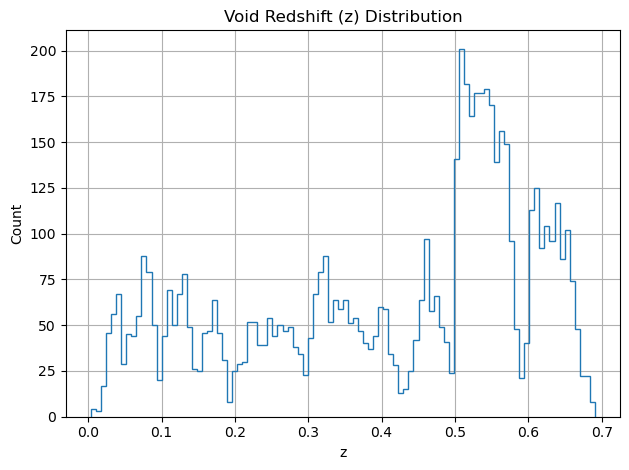

In [531]:
# Plot void z histogram
plt.hist(voids['z'], bins=100, histtype="step") # 100 bins chosen arbitrarily
plt.xlabel('z')
plt.ylabel('Count')
plt.title('Void Redshift (z) Distribution')
plt.grid()
plt.tight_layout()

# z range
max_z = voids['z'].max()
min_z = voids['z'].min()
print(f"Max z: {max_z}\nMin z: {min_z}\nRange: {max_z - min_z} ")

In [532]:
# Calculating comoving distance from z
# NOTE: WMAP9 uses H0 = 69.3 (km/s)/Mpc compared to 69.7 used to calculate h. This should be okay. 7/5/23
void_cmvd = cosmo.comoving_distance(voids['z']) # Comoving distance to void center
voids['cmvd_Mpc'] = void_cmvd.value # add it to data table

# Calculating effective radii in angular seperation units
H = 69.7 * ((u.km/u.s)/u.Mpc) # H0 hubble constant used for this study
h = H/(100 * ((u.km/u.s)/u.Mpc))

void_r = (voids['Reff']) / h.value # [Mpc]
voids['Reff_Mpc'] = void_r

#radius of voids in angular seperation
void_r_angs = np.arctan2(void_r,void_cmvd.value) * (180/math.pi) # Deg
voids['r_ang_deg'] = void_r_angs


## Checking for uniqueness in Void data

In [533]:
# Check for unique IDs
id_count = Counter(voids['ID']) # Uh oh we have a few duplicate ID's
keys = list(id_count)
duplicate_ids = [keys for keys, count in id_count.items() if count>1]

In [534]:
id_count;

In [535]:
duplicates = voids[voids.duplicated()]
# print(duplicates)
# But pandas method says they are all unique. 

In [536]:
seps = {}
problematic = {}
# Loop through duplicate id's and determine if their angular seperation is less
# than 5 degrees
# Save duplicate void id. seperation, radius of each void and their redshift
for id in duplicate_ids:
    # Find index
    mask = voids['ID'].isin([id])
    table = voids[mask][:]
    RAs = table[:]['RAdeg'].values * u.deg
    DEs = table[:]['DEdeg'].values * u.deg
    coords = SkyCoord(RAs, DEs)
    temp_seps = dist_w_skycoord(coords)
    
    seps[str(id)] = temp_seps
    if min(temp_seps) < 5:
        problematic[str(id)] = {'seps': temp_seps,
                                'radius': table[:]['r_ang_deg'].values,
                                'z': table[:]['z'].values}

In [537]:
# Display problematic void id's
problematic; # Two duplicate id's were problematic

In [538]:
# Not used anywhere else in the code. Will probably get deleted
# duplicate_mask = voids['ID'].isin(duplicate_ids)

In [539]:
# Void coordinates in celestial frame
void_coords_cel = SkyCoord(voids['RAdeg'].values*u.deg,
                       voids['DEdeg'].values*u.deg,
                       equinox='J2000')

In [540]:
# Out of curiosity. I wanted to see what a histogram for void seperations would
# look like. 
# void_seps = dist_w_skycoord(void_coords_cel) #plot super anisotropic


Notes on Void Catalog from 2017:
    ZOBOV void finding algorithm
    10,643 before "quality cuts"
    1,228 Voids after "quality cuts" 
    effective radii spanning 20-100 Mpc/h
    Uses SDSS DR 12 CMASS and LOWZ galaxy samples
    z: 0.2 - 0.43 LOWZ Sample cut
    z: 0.43 - 0.7 CMASS sample cut
    z: 0.2 - 0.7 total 

    
Notes on Void Catalog from 2012:
    z: 0.2 - 0.44
    Uses main sample and lumious red galaxy (LRG) from SDSS DR 7
    Effective radii 5 - 135 Mpc/h
    Modified Version of ZOBOV (parameter free)

    

# VHE Data Processing

## Cleaning Data

In [541]:
# import packages
fhl3 = fits.open('3FHL.fit')

In [542]:
# Determine where data is stored in fits file
# FERMI DATA USES FK5 FRAME WRONG
# Equatorial
fhl3.info() # Used to see scope of data
w = wcs.WCS(fhl3[1].header)
print(w) # Used to find out what frame the data uses
# w.world_axis_physical_types

hdu = fits.open('3FHL.fit')[1]
wcs = WCS(hdu.header)

Filename: 3FHL.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  LAT_Point_Source_Catalog    1 BinTableHDU    258   1556R x 44C   [18A, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, 11A, E, E, E, E, E, E, 5E, 10E, 5E, 5E, E, E, E, I, 18A, 18A, A, 21A, 7A, 26A, 26A, E, E, E, E]   
  2  ExtendedSources    1 BinTableHDU     82   55R x 11C   [17A, E, E, E, E, 11A, E, E, E, 11A, 24A]   
  3  ROIs          1 BinTableHDU    103   741R x 10C   [I, E, E, E, E, E, E, E, E, E]   
  4  EnergyBounds    1 BinTableHDU     48   5R x 3C   [E, E, E]   
WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 366  1556


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 57236.967546 from DATE-END'. [astropy.wcs.wcs]


In [543]:
# Read in 3FHL Fits file
data = QTable.read('3FHL.fit', hdu=1)

In [544]:
data  # Used to see data table 

Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Signif_Avg,Pivot_Energy,Flux_Density,Unc_Flux_Density,Flux,Unc_Flux,Energy_Flux,Unc_Energy_Flux,Signif_Curve,SpectrumType,Spectral_Index,Unc_Spectral_Index,beta,Unc_beta,PowerLaw_Index,Unc_PowerLaw_Index,Flux_Band,Unc_Flux_Band,nuFnu,Sqrt_TS_Band,Npred,HEP_Energy,HEP_Prob,Variability_BayesBlocks,Extended_Source_Name,ASSOC_GAM,TEVCAT_FLAG,ASSOC_TEV,CLASS,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,Redshift,NuPeak_obs
,deg,deg,deg,deg,deg,deg,deg,,,GeV,ph / (GeV s cm2),ph / (GeV s cm2),ph / (s cm2),ph / (s cm2),erg / (s cm2),erg / (s cm2),,,,,,,,,ph / (s cm2),ph / (s cm2),erg / (s cm2),,,GeV,,,,,,,,,,,,,Hz
bytes18,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes11,float32,float32,float32,float32,float32,float32,float32[5],"float32[5,2]",float32[5],float32[5],float32,float32,float32,int16,bytes18,bytes18,bytes1,bytes21,bytes7,bytes26,bytes26,float32,float32,float32,float32
3FHL J0001.2-0748,0.3107,-7.8075,89.0094,-67.3118,0.0424,0.0424,———,64,5.362,23.73,5.3174e-13,2.0975e-13,2.9593e-11,1.1704e-11,1.6752e-12,1.0743e-12,1.02,PowerLaw,1.6724,0.8274,0.5916,0.7129,2.2226,0.4808,1.1127661292409385e-11 .. 1.142230074863933e-22,-6.076397631588071e-12 .. 6.529277118971777e-12,3.53398896518059e-13 .. 1.1789071844646614e-22,3.1458344 .. 0.0,7.63,86.975,0.9964,1,,3FGL J0001.2-0748,N,,bll,PMN J0001-0746,,0.9974,0.9721,--,306196372258816.0
3FHL J0001.9-4155,0.4849,-41.9303,334.1216,-72.0697,0.1018,0.1018,———,429,5.638,28.42,5.4253e-13,1.6839e-13,4.3230e-11,1.3428e-11,3.4900e-12,1.8276e-12,0.45,PowerLaw,1.7819,0.4941,0.1187,0.2798,1.9418,0.3100,2.1003905212313434e-11 .. 1.928788526283026e-18,-8.032090617615673e-12 .. 5.859409745595512e-12,6.745224496139401e-13 .. 2.0786751008437066e-18,4.899907 .. 0.0,12.51,266.625,0.9622,1,,3FGL J0002.2-4152,N,,bcu,1RXS J000135.5-415519,,0.9960,0.0000,--,6309576467021824.0
3FHL J0002.1-6728,0.5283,-67.4825,310.0868,-48.9549,0.0357,0.0357,———,386,8.470,20.82,1.2062e-12,3.2106e-13,5.0093e-11,1.3349e-11,2.3058e-12,9.5580e-13,1.53,PowerLaw,1.8109,0.6260,0.7933,0.5956,2.4285,0.3710,2.4550663585420907e-11 .. 1.9009975647596715e-21,-8.634194921530725e-12 .. 4.802190329417089e-12,7.734069461251547e-13 .. 1.9026535415719115e-21,5.900217 .. 0.0,17.11,52.152,0.9988,1,,3FGL J0002.0-6722,N,,bcu,SUMSS J000215-672653,,0.0000,0.9395,--,4466832022962176.0
3FHL J0003.3-5248,0.8300,-52.8150,318.9245,-62.7936,0.0425,0.0425,———,145,7.229,23.66,7.5065e-13,2.3102e-13,4.1560e-11,1.2839e-11,2.2874e-12,1.1145e-12,1.70,PowerLaw,1.6010,0.5644,0.9972,0.1721,2.2481,0.3732,2.0886386370433385e-11 .. 7.586755528904005e-23,-8.143967271390107e-12 .. 5.312990065259315e-12,6.626545557934793e-13 .. 7.800201726106361e-23,5.298393 .. 0.0,13.02,67.310,0.9636,1,,3FGL J0003.2-5246,N,,bcu,RBS 0006,,0.9996,0.9716,--,7.079464172466995e+16
3FHL J0007.0+7303,1.7647,73.0560,119.6625,10.4666,0.0101,0.0101,———,277,75.265,12.80,1.7436e-10,7.5950e-12,1.5308e-09,6.1341e-11,3.6785e-11,1.5973e-12,3.24,LogParabola,3.1751,0.2103,0.9021,0.2659,3.8315,0.1141,1.3514667163150307e-09 .. 3.839894826201812e-18,-5.7581186346800095e-11 .. 4.060417800599847e-12,4.109738938051777e-11 .. 2.923114423287347e-18,71.33829 .. 0.0,654.15,60.292,0.9972,1,,3FGL J0007.0+7302,E,CTA 1,PSR,LAT PSR J0007+7303,,1.0000,0.0000,--,———
3FHL J0007.9+4711,1.9931,47.1920,115.3093,-15.0354,0.0196,0.0196,———,302,17.774,17.19,5.9778e-12,8.7683e-13,1.5131e-10,2.2181e-11,5.1444e-12,1.0540e-12,0.56,PowerLaw,2.6783,0.4196,0.1696,0.3282,2.8588,0.2685,1.0582407172776698e-10 .. 1.9819722609314394e-16,-1.7538378735415527e-11 .. 4.823510948298582e-12,3.278615009691399e-12 .. 1.866829778455242e-16,15.209969 .. 0.0,50.95,68.152,0.9759,1,,3FGL J0008.0+4713,N,,bll,MG4 J000800+4712,,1.0000,0.9873,0.2800,2511884242649088.0
3FHL J0008.4-2339,2.1243,-23.6514,50.2908,-79.7021,0.0366,0.0366,———,517,9.679,16.96,3.0610e-12,7.3475e-13,7.46

In [545]:
# Clean 3FHL data to galactic sources only
class_data = data['CLASS']

# mask = (class_data == 'sbg    ') | \
#        (class_data == 'bll    ') | \
#        (class_data == 'fsrq   ') | \
#        (class_data == 'agn    ') | \
#        (class_data == 'rdg    ') | \
#        (class_data == 'bcu    ') # Ugly but it works

anti_mask = ~((class_data == 'psr    ') | \
              (class_data == 'PSR    ') | \
              (class_data == 'pwn    ') | \
              (class_data == 'PWN    ') | \
              (class_data == 'snr    ') | \
              (class_data == 'SNR    ') | \
              (class_data == 'hmb    ') | \
              (class_data == 'HMB    ') | \
              (class_data == 'BIN    ') | \
              (class_data == 'sfr    ') | \
              (class_data == 'SFR    ')
              ) # Ugly but it works

gal_src = data[anti_mask] # Cleaned 3FHL data that contains data from galactic sources only

In [546]:
Counter(gal_src['CLASS']); # Matches Table 2 in 3FHL Paper we are good to go

In [547]:
# Filtering out sources without Redshift information
z_data = gal_src['Redshift']
z_mask = ~np.ma.getmaskarray(z_data) # z data is float, if no z data, it is an np.ma.mask object
gal_src_wz = gal_src[z_mask] # Galactic Sources with redshift information

Max z: 2.5339999198913574
Min z: 0.003000000026077032
Range: 2.5309998989105225 


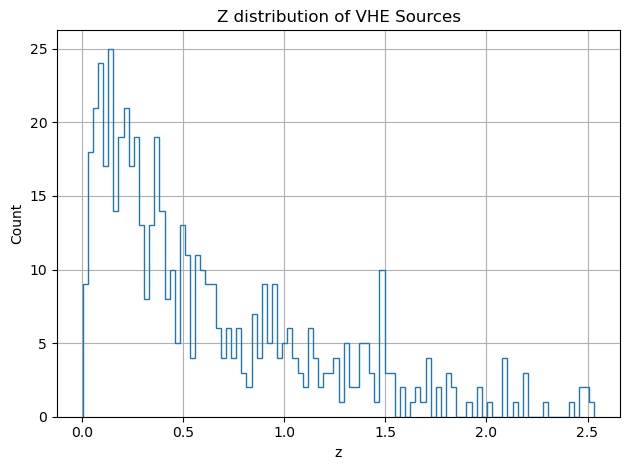

In [548]:
# Plots histogram of Gamma Ray Source Redshift Distribution
plt.hist(gal_src_wz['Redshift'], bins=100, histtype="step") # 100 bins chosen arbitrarily
plt.xlabel('z')
plt.ylabel('Count')
plt.title('Z distribution of VHE Sources')
plt.grid()
plt.tight_layout()

# z range
max_z = gal_src_wz['Redshift'].max()
min_z = gal_src_wz['Redshift'].min()
print(f"Max z: {max_z}\nMin z: {min_z}\nRange: {max_z - min_z} ")

Plot of Redshift distribution for extra galactic gamma ray sources

## Analysis

### Apply ± 10 deg mask to Fermi Data

In [549]:
ahh = gal_src_wz
temp =ahh[:]['Source_Name','RAJ2000', 'DEJ2000', 'Redshift', 
             'TEVCAT_FLAG',
             'Spectral_Index', 'Unc_Spectral_Index',
             'Flux', 'Unc_Flux',
             ] 

work_vhe = temp.to_pandas() # Create GRS pandas table to work with throughout the code


# Flux_Band present multidimensional Issues
problem = ahh[:]['Flux_Band'].value
problem2 = ahh[:]['Unc_Flux_Band'].value

problem = np.vstack(problem) # This seems to do it
problem2 = np.reshape(problem2,(problem2.shape[0], -1)) # This puts them right next to each other so 1a 1b 2a 2b

col_names_flux = [f"Flux_Band_{band}" for band in range(5)]
col_names_unc = [f"Unc_Flux_Band_{band}_{state}" for band in range(5) for state in ['a', 'b']]

flux_band_df = pd.DataFrame(problem, columns=col_names_flux)
unc_df = pd.DataFrame(problem2, columns=col_names_unc)

unc_df = unc_df.astype(np.float64) # VERY unexpected bug. different data types caused issues

work_vhe = pd.concat([work_vhe ,flux_band_df, unc_df], axis=1)


In [550]:
ahh.show_in_notebook()


idx,Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Signif_Avg,Pivot_Energy,Flux_Density,Unc_Flux_Density,Flux,Unc_Flux,Energy_Flux,Unc_Energy_Flux,Signif_Curve,SpectrumType,Spectral_Index,Unc_Spectral_Index,beta,Unc_beta,PowerLaw_Index,Unc_PowerLaw_Index,Flux_Band,Unc_Flux_Band,nuFnu,Sqrt_TS_Band,Npred,HEP_Energy,HEP_Prob,Variability_BayesBlocks,Extended_Source_Name,ASSOC_GAM,TEVCAT_FLAG,ASSOC_TEV,CLASS,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,Redshift,NuPeak_obs
,,deg,deg,deg,deg,deg,deg,deg,,,GeV,ph / (GeV s cm2),ph / (GeV s cm2),ph / (s cm2),ph / (s cm2),erg / (s cm2),erg / (s cm2),,,,,,,,,ph / (s cm2),ph / (s cm2),erg / (s cm2),,,GeV,,,,,,,,,,,,,Hz
0,3FHL J0007.9+4711,1.9931,47.1920,115.3093,-15.0354,0.0196,0.0196,———,302,17.774,17.19,5.9778e-12,8.7683e-13,1.5131e-10,2.2181e-11,5.1444e-12,1.0540e-12,0.56,PowerLaw,2.6783,0.4196,0.1696,0.3282,2.8588,0.2685,1.0582407172776698e-10 .. 1.9819722609314394e-16,-1.7538378735415527e-11 .. 4.823510948298582e-12,3.278615009691399e-12 .. 1.866829778455242e-16,15.209969 .. 0.0,50.95,68.152,0.9759,1,,3FGL J0008.0+4713,N,,bll,MG4 J000800+4712,,1.0000,0.9873,0.2800,2511884242649088.0
1,3FHL J0008.4-2339,2.1243,-23.6514,50.2908,-79.7021,0.0366,0.0366,———,517,9.679,16.96,3.0610e-12,7.3475e-13,7.4602e-11,1.7896e-11,2.4733e-12,8.1716e-13,0.34,PowerLaw,2.7388,0.7145,0.1737,0.5618,2.9070,0.4520,5.8049919038349884e-11 .. 1.111731066388696e-20,-1.4419373681184844e-11 .. 6.106610009326552e-12,1.7951775049124263e-12 .. 1.0403957858439471e-20,9.133706 .. 0.0,19.83,71.122,0.9968,1,,3FGL J0008.6-2340,N,,bll,RBS 0016,,0.9996,0.9673,0.1470,524807791706112.0
2,3FHL J0013.8-1855,3.4684,-18.9169,74.5314,-78.0876,0.0485,0.0485,———,152,5.272,18.94,9.4557e-13,3.6339e-13,3.1086e-11,1.1945e-11,1.2427e-12,7.0538e-13,1.06,PowerLaw,1.9438,0.9164,0.9135,0.8288,2.6020,0.5839,1.8761324091509657e-11 .. 2.40103979326481e-18,-8.030479926868228e-12 .. 6.247884588167496e-12,5.870442478482507e-13 .. 2.3435759697010573e-18,4.4304204 .. 0.0,8.19,37.217,0.9861,1,,3FGL J0013.9-1853,P,SHBL J001355.9-185406,bll,RBS 0030,,0.9995,0.9772,0.0950,5.260180879887565e+16
3,3FHL J0018.6+2946,4.6525,29.7821,114.4798,-32.5503,0.0312,0.0312,———,522,7.917,29.20,6.0010e-13,1.7106e-13,5.0577e-11,1.4495e-11,3.8639e-12,1.7982e-12,0.92,PowerLaw,1.6802,0.4901,0.2639,0.3270,1.9816,0.2912,2.3603334564636924e-11 .. 0.0,-9.441282824984576e-12 .. 5.700210269077299e-12,7.568023898535392e-13 .. 0.0,4.5989604 .. 0.0,15.13,127.317,0.9988,1,,3FGL J0018.4+2947,N,,bll,RBS 0042,,0.9985,0.9711,0.1000,5.915607492145971e+16
4,3FHL J0030.2-1648,7.5726,-16.8002,96.4971,-78.5715,0.0318,0.0318,———,152,8.516,26.36,8.6879e-13,2.3373e-13,5.9813e-11,1.6105e-11,4.2572e-12,1.9438e-12,1.45,PowerLaw,1.6246,0.4902,0.4492,0.3985,2.0343,0.2898,2.6100141145568578e-11 .. 1.9261018022944232e-17,-9.450762221419051e-12 .. 6.531485421956695e-12,8.351058559952218e-13 .. 2.0461253783036225e-17,5.013004 .. 0.0,15.78,97.084,0.9994,1,,3FGL J0030.2-1646,C,,bll,1RXS J003019.6-164723,,0.9999,0.9042,2.1000,3311314826952704.0
5,3FHL J0030.5-0210,7.6422,-2.1800,110.7217,-64.5559,0.0624,0.0624,———,215,5.144,11.86,5.9322e-12,2.3231e-12,3.2847e-11,1.2794e-11,6.3686e-13,2.5564e-13,0.22,PowerLaw,6.3063,2.4946,0.9330,2.1235,6.7050,2.2715,3.242826493443651e-11 .. 6.498298176577124e-21,-1.1318679500604834e-11 .. 5.991703227320455e-12,8.909752276242688e-13 .. 4.5469371062990506e-21,5.941769 .. 0.0,8.41,16.008,0.9707,1,,3FGL J0030.7-0209,N,,bcu,PKS B0027-024,,0.9964,0.9466,2.0900,3767039950848.0
6,3FHL J0033.5-1921,8.3929,-19.3575,94.1778,-81.2144,0.0162,0.0162,———,152,30.088,23.11,8.3633e-12,8.0143e-13,4.3840e-10,4.2022e-11,2.5295e-11,4.1163e-12,2.28,PowerLaw,1.9158,0.1942,0.2863,0.1465,2.2057,0.1188,2.346780825224215e-10 .. 4.1734760877291346e-18,-2.990207734199224e-11 .. 6.343457443352962e-12,7.458034190221952e-12 .. 4.318568116664305e-18,21.258574 .. 0.0,115.95,235.269,0.9591,1,,3FGL J0033.6-1921,P,KUV 00311-1938,bll,KUV 00311-1938,,1.0000,0.9950,0.6

In [551]:
ahh[281]["Flux_Band"]

<Quantity [4.3121695e-10, 2.1590235e-10, 8.6472940e-11, 1.7526697e-11,
           9.3267121e-20] ph / (s cm2)>

In [552]:
# for col in flux_band_df.columns:
    # print(flux_band_df[col].dtype)

In [553]:
# for col in unc_df.columns:
    # print(unc_df[col].dtype) # This was the problem

In [554]:

work_vhe = work_vhe.rename(columns={'RAJ2000': 'RAdeg',
                                    'DEJ2000': 'DEdeg',
                                    'Redshift': 'z'}) # MUST BE CONSISTENT WITH CONVENTION USED IN DATAPARSER

vhe_cmvd = cosmo.comoving_distance(work_vhe['z']) # Comoving distance to void center
work_vhe['cmvd_Mpc'] = vhe_cmvd.value # add it to data table

# Find sources in front of our furthest voids
mask_z = work_vhe['z'] <= max(voids.z)

# Keep those sources
work_vhe = work_vhe[mask_z] # After this mask. we drop to 367 sources


work_vhe = work_vhe.reset_index(drop=True)

vhe_coords_cel = SkyCoord(work_vhe.RAdeg.values*u.deg, work_vhe.DEdeg.values * u.deg, equinox='J2000', frame='fk5')
vhe_coords_gal =  vhe_coords_cel.galactic # book keeping. Source coords in galactic coords
work_vhe['RAdeg_gal'] = vhe_coords_gal.l.deg
work_vhe['DEdeg_gal'] = vhe_coords_gal.b.deg
# work_vhe['RAdeg'] += 45


# Apply SDSS footprint mask
m1 = ~get_mask(work_vhe,
                  RA_lo=0, RA_hi=110,
                  DE_lo=32)

m2 = ~get_mask(work_vhe,
                  DE_lo=65)
m3 = ~get_mask(work_vhe,
                   DE_hi=-10)
m4 = ~get_mask(work_vhe,
                  RA_lo=270,
                  RA_hi=315)
m5 = ~get_mask(work_vhe,
               RA_hi=270,
               RA_lo=262)
m6 = ~get_mask(work_vhe,
               RA_lo=265,
               DE_lo=37)
m7 =  ~get_mask(work_vhe,
                RA_lo=45,
                RA_hi=100)
m8 = ~get_mask(work_vhe,
               RA_lo=225,
               RA_hi=320,
               DE_hi=0)
m9 = ~get_mask(work_vhe,
               RA_lo = 45,
               RA_hi=182,
               DE_hi=0)
m10 = ~get_mask(work_vhe,
                RA_lo=315,
                DE_hi=-5)
m11 = ~get_mask(work_vhe,
                RA_lo=10,
                RA_hi=15,
                DE_hi=9)
m = get_ands([m1,
              m2,
              m3,
              m4,
              m5,
              m6,
              m7,
              m8,
              m9,
              m10,
              m11])
work_vhe = work_vhe[m].copy()

# Indices of gamma ray sources that fall outside of SDSS footprint
exclude = [21,
           98,
           90,
           107,
           279,
           277,
           278,
           241,
           257,
           325,
           45,
           40,
           33,
           35,
           31,
           36,
           29
           ]

# Final Gamma Ray Source table after table has been cleaned against galactic mask
# and data outside of SDSS footprint has been removed.
work_vhe = work_vhe.loc[~work_vhe.index.isin(exclude)]



In [555]:
# Adding the original index numbers to check if my index method is working as 
# intended. In general, the actual index of the data should match OG_index
# I can not save this before because i reset the indices before applying the
# SDSS mask. I would have to redo the SDSS mask with the original indices. 
work_vhe.insert(0, 'OG_idx', work_vhe.index)

In [556]:
# Display table
work_vhe

,OG_idx,Source_Name,RAdeg,DEdeg,z,TEVCAT_FLAG,Spectral_Index,Unc_Spectral_Index,Flux,Unc_Flux,...,Unc_Flux_Band_1_b,Unc_Flux_Band_2_a,Unc_Flux_Band_2_b,Unc_Flux_Band_3_a,Unc_Flux_Band_3_b,Unc_Flux_Band_4_a,Unc_Flux_Band_4_b,cmvd_Mpc,RAdeg_gal,DEdeg_gal
3,3,b'3FHL J0018.6+2946 ',4.652533,29.782143,0.100,b'N',1.680245,0.490069,5.057661e-11,1.449517e-11,...,9.591453e-12,-4.597607e-12,6.873026e-12,NaN,4.970725e-12,NaN,5.700210e-12,422.982362,114.479801,-32.550272
5,5,b'3FHL J0037.8+1239 ',9.461507,12.651176,0.089,b'N',2.170168,0.693109,5.253420e-11,1.595452e-11,...,9.619860e-12,-2.573456e-12,4.771719e-12,NaN,5.394360e-12,NaN,6.076125e-12,377.399142,117.760924,-50.084057
12,12,b'3FHL J0109.1+1817 ',17.291544,18.284430,0.443,b'N',3.619309,0.954015,5.499022e-11,1.554123e-11,...,5.467250e-12,-2.255967e-12,4.836382e-12,NaN,5.191210e-12,NaN,6.429806e-12,1722.784655,128.824926,-44.384373
14,14,b'3FHL J0112.1+2245 ',18.032927,22.755352,0.265,b'P',2.591132,0.260177,5.129682e-10,4.337492e-11,...,2.299821e-11,-5.949668e-12,7.784014e-12,NaN,5.235033e-12,NaN,5.626691e-12,1077.800370,129.151333,-39.866364
17,17,b'3FHL J0114.8+1324 ',18.706766,13.404436,0.583,b'N',1.956460,0.518569,9.477722e-11,2.022495e-11,...,1.231064e-11,-5.206293e-12,7.654756e-12,NaN,5.346775e-12,NaN,6.013239e-12,2186.405655,131.632717,-49.071776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,347,b'3FHL J2314.0+1445 ',348.503143,14.754387,0.164,b'C',1.573969,0.426425,8.701453e-11,1.930824e-11,...,1.367902e-11,-5.954401e-12,8.318516e-12,NaN,5.387090e-12,NaN,6.135942e-12,683.451557,90.529233,-41.906358
349,349,b'3FHL J2322.6+3436 ',350.663483,34.605709,0.098,b'C',1.639653,0.343481,6.472586e-11,1.591682e-11,...,1.082649e-11,-4.084045e-12,6.411419e-12,-3.561680e-12,5.748201e-12,NaN,5.621589e-12,414.712131,102.902685,-24.789353
356,356,b'3FHL J2338.9+2123 ',354.744965,21.396553,0.291,b'N',1.909309,0.666608,4.831319e-11,1.504136e-11,...,9.620636e-12,-4.867777e-12,7.492724e-12,NaN,5.283884e-12,NaN,5.884382e-12,1175.980669,101.252166,-38.405682
358,358,b'3FHL J2343.6+3439 ',355.901154,34.651287,0.366,b'C',1.790195,0.490599,6.570089e-11,1.642876e-11,...,1.044849e-11,-6.175583e-12,8.506036e-12,NaN,6.402267e-12,NaN,5.499488e-12,1451.554321,107.425531,-26.169645


In [557]:
# # work_data = gal_src # simply for bookkeeping in case we want to include sources that do not have z info

# vhe_coords_cel = SkyCoord(work_vhe.RAdeg.values*u.deg, work_vhe.DEdeg.values * u.deg, equinox='J2000', frame='fk5')
# vhe_coords_gal =  vhe_coords_cel.galactic # book keeping. Source coords in galactic coords
# work_vhe['RAdeg_gal'] = vhe_coords_gal.l.deg
# work_vhe['DEdeg_gal'] = vhe_coords_gal.b.deg


In [558]:
# Generate Skycoord Objects
# Skycoords of GRS in celestial
# Turns outs the fermi data is in equatorial frame
vhe_coords_cel = SkyCoord(work_vhe.RAdeg.values*u.deg, work_vhe.DEdeg.values * u.deg, 
                          equinox='J2000', 
                          frame='fk5')
vhe_coords_gal =  vhe_coords_cel.galactic # book keeping. Source coords in galactic coords

void_coords_gal = void_coords_cel.galactic # Moore bookkeeping. Skycoord of voids in galactic

seps = vhe_coords_cel.separation(vhe_coords_cel) # This returns the expected 0 seperation
Counter(vhe_coords_cel.separation(vhe_coords_cel)); # Confirming they are all 0 and array length matches source array


In [559]:
# Apply galactic mask
# # Find fermi data with |b| < 10
MASK_deg = 10 # Degrees. global constant
masked = True
if masked:
    mask_fermi = abs(vhe_coords_gal.b.value) <= MASK_deg

    # Keep the sources with |b| > 10
    vhe_coords_gal = vhe_coords_gal[~mask_fermi] # Drops 20 sources
    vhe_coords_cel = vhe_coords_gal.fk5 # Bookkeping. Go back to Celestial coordinates

### Plot Gamma-Ray Sources and Voids

/var/folders/pj/_3cv5_xd2sz143_b3_wm1xk40000gn/T/ipykernel_16733/406186901.py:39: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [30]  # Adjust the marker size for the Cosmic Voids label


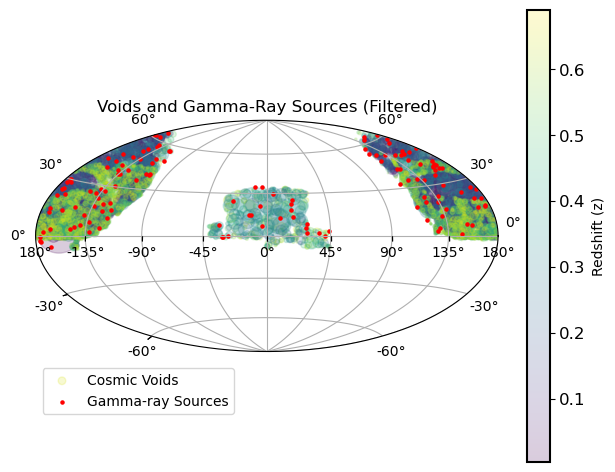

In [560]:

# Plot Sources in galactic frame
ax = plt.axes(projection="geo aitoff")
ax.grid()

r_ang = voids[:]['r_ang_deg']
z_values = voids['z']
norm = Normalize(vmin=min(z_values), vmax=max(z_values))

colormap = 'viridis' 

# Plot the cosmic voids with proper color mapping
scatter = ax.scatter(void_coords_cel.spherical.lon.deg, void_coords_cel.spherical.lat.deg,
                     transform=ax.get_transform('world'),
                     s=math.pi*r_ang**2,
                     marker='o',
                     label='Cosmic Voids',
                     c=voids['z'],  # Use the redshift values directly
                     cmap=colormap,  # Set the colormap
                     alpha=0.2)

# Set color limits to match data range
vmin = min(voids['z'])
vmax = max(voids['z'])
scatter.set_clim(vmin, vmax)
ax.scatter(vhe_coords_cel.spherical.lon.deg, vhe_coords_cel.spherical.lat.deg,
           transform=ax.get_transform('world'),
           marker="o",
           facecolor='red',
           s =5,
           label='Gamma-ray Sources'
          )


# Add a color bar using the scatter plot as the mappable
colorbar = plt.colorbar(scatter, ax=ax, label='Redshift (z)')
colorbar.ax.tick_params(labelsize=12)  # Adjust font size of color bar labels
colorbar.outline.set_linewidth(1.5)     # Set color bar outline linewidth
legend = plt.legend(loc="lower left", bbox_to_anchor=(0.0, -0.3), bbox_transform=ax.transAxes)
legend.legendHandles[0]._sizes = [30]  # Adjust the marker size for the Cosmic Voids label

plt.subplots_adjust(bottom=0.15, right=0.8)  # Increase the bottom and right margins

plt.title(f"Voids and Gamma-Ray Sources (Filtered)")
plt.tight_layout(pad=1)



plt.show()

# Voidiness Calculation

In [561]:
# Similarly, saving the original void index to ensure indexing method is working
# as intended
voids.insert(0, 'OG_idx', voids.index )

In [562]:
voids

,OG_idx,ID,RAdeg,DEdeg,z,Reff,DR,label,cmvd_Mpc,Reff_Mpc,r_ang_deg
0,0,60,114.782,37.641,0.64800,32.298,12,Mao,2389.186928,46.338594,1.111120
1,1,10020,184.261,1.326,0.50000,15.964,12,Mao,1916.069417,22.903874,0.684857
2,2,11496,124.855,3.090,0.64800,52.473,12,Mao,2389.186928,75.284075,1.804812
3,3,15935,230.976,13.239,0.45900,38.683,12,Mao,1777.677557,55.499283,1.788200
4,4,4407,237.406,16.985,0.46300,63.467,12,Mao,1791.322692,91.057389,2.909982
...,...,...,...,...,...,...,...,...,...,...,...
6366,6366,81748,200.350,23.440,0.63004,41.540,10,cmass3,2333.924432,59.598278,1.462767
6367,6367,60588,162.750,12.590,0.67881,37.440,10,cmass3,2482.646384,53.715925,1.239490
6368,6368,102343,203.950,8.520,0.66704,37.300,10,cmass3,2447.141939,53.515065,1.252767
6369,6369,51804,235.030,31.090,0.62018,27.510,10,cmass3,2303.337838,39.469154,0.981703


In [563]:
# One of the first attempts. Keeping it for posterity
vhes ={}

bad_ints = {'v_idx': [],
            's_idx': []}
# ks = []
for v_idx in voids.index:
    temp_vhe = work_vhe.copy() # Save a fresh copy of work vhe

    # Grab void data
    void_ra, void_de, = voids.loc[v_idx,['RAdeg', 'DEdeg']]
    r_ang_deg, z, v_cmvd, v_r_mpc = voids.loc[v_idx,['r_ang_deg', 'z', 'cmvd_Mpc', 'Reff_Mpc']]

    temp_void_coord = SkyCoord(void_ra * u.deg, void_de *u.deg)
    vhe_coords =  SkyCoord(temp_vhe.RAdeg.values * u.deg, temp_vhe.DEdeg.values * u.deg)

    dist = temp_void_coord.separation(vhe_coords).deg

    radius_mask = dist  < r_ang_deg

    # If any grs are within radius of void
    if any(radius_mask):
        # Get indices of sources
        s_idx  = temp_vhe.index[radius_mask]
    else:
        continue # No grs within this void

    # Filter by having them be at least inside the void
    # behind_mask = temp_vhe.loc[s_idx, 'cmvd_Mpc'] > (v_cmvd  + 2 * v_r_mpc)
    behind_mask = temp_vhe.loc[s_idx, 'cmvd_Mpc'] > (v_cmvd  - v_r_mpc)

    if any(behind_mask):
        s_idx = behind_mask.index[behind_mask]
    else:
        continue


    for grs_idx in s_idx:
        # ra, de, s_cmvd = temp_vhe.loc[grs_idx, ['RAdeg', 'DEdeg', 'cmvd_Mpc']]
        ra, de, s_cmvd = work_vhe.loc[grs_idx, ['RAdeg', 'DEdeg', 'cmvd_Mpc']]
        singular_vhe_skycoord = SkyCoord(ra * u.deg, de*u.deg)

        s_v_dist = temp_void_coord.separation(singular_vhe_skycoord)

        if s_v_dist.deg < r_ang_deg:
            # Last check to ensure sources are inside voids
        
        ## Just testing index matches og index. it looks like we're safe. 
        # print(temp_vhe.loc[grs_idx, 'OG_idx'], grs_idx)
            if grs_idx != temp_vhe.loc[grs_idx, 'OG_idx']:
                print("uh oh ")
                print(grs_idx, temp_vhe.loc[grs_idx, 'OG_idx'])

            void_int, Cv_i, bad_int = calulate_voidy_int(void_ra, void_de, v_cmvd, v_r_mpc,
                                        ra, de, s_cmvd,
                                        s_v_dist)
            # print(void_int)

            if bad_int:
                bad_ints['v_idx'].append(v_idx)
                bad_ints['s_idx'].append(grs_idx)
            data = vhes.setdefault(grs_idx, {
                                        'void_idx': [],
                                        'Cv': [],
                                        'intervals': [],
                                        'OG_idx': []
                                        # 'idx_match': []
                                    })    
                    
            og_idx = work_vhe.loc[grs_idx, 'OG_idx']
            data['void_idx'].append(v_idx)
            data['Cv'].append(Cv_i)
            data['intervals'].append(void_int)
            data['OG_idx'].append(og_idx)


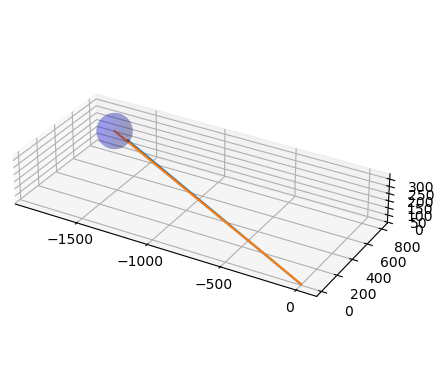

Angle Test: 0


In [564]:
v_idxs = bad_ints['v_idx']
s_idxs = bad_ints['s_idx']

fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")

for v_idx, s_idx in zip(v_idxs, s_idxs):
    # Grab void data
    void_ra, void_de, = voids.loc[v_idx,['RAdeg', 'DEdeg']]
    r_ang_deg, z, v_cmvd, v_r_mpc = voids.loc[v_idx,['r_ang_deg', 'z', 'cmvd_Mpc', 'Reff_Mpc']]
    temp_void_coord = SkyCoord(void_ra * u.deg, void_de *u.deg)



    s_ra, s_de, s_cmvd = work_vhe.loc[s_idx, ['RAdeg', 'DEdeg', 'cmvd_Mpc']]
    singular_vhe_skycoord = SkyCoord(s_ra * u.deg, s_de*u.deg)

    s_v_dist = temp_void_coord.separation(singular_vhe_skycoord)

    bad_counter = 0

    # Passes the angular distance check
    if r_ang_deg < s_v_dist.deg:
        bad_counter += 1

    v_de = void_de
    v_ra = void_ra    
    # Collat
    v_th = 90 - v_de
    s_th = 90 - s_de

    v_th *= (math.pi)/180
    s_th *= (math.pi)/180
    

    
    v_ra *= math.pi/180
    s_ra *= math.pi/180

    rv_cart = cart_comp(v_cmvd, v_th, v_ra)
    rs_cart = cart_comp(s_cmvd, s_th, s_ra)

    # Calculating intersection and intersectoin intervals
    w1_vec = w1(rv_cart, rs_cart)
    # d_vec = rv_cart - w1_vec
    
    # Cv_i = 2 *np.sqrt(v_r_mpc**2 - mag(d_vec)**2)
    little_d = s_v_dist.rad * v_cmvd # Arclength approximation

    ##
    Cv_i = other_voidy_calc(little_d, v_r_mpc) # Cv_i no longer nanny
    ##

    ## Normalization working properly
    w2 = Cv_i/2 * (rs_cart / mag(rs_cart))
    ## 

    T1 = w1_vec - w2

    T2 = T1 + 2 * w2


    n1 = mag(T1)/s_cmvd
    n2 = mag(T2)/s_cmvd

    if n2 > 1:
        n2 = 1

    interval = I.closed(n1, n2)
    if interval.is_empty():
        bad_int = True
    else:
        bad_int = False
    # return I.closed(n1, n2), Cv_i, bad_int
    # ax.plot(np.array([0,0,0]), rs_cart[0], [1], rs_cart[2])
    ax.plot([0, rs_cart[0]],[0, rs_cart[1]],[0, rs_cart[2]])
    ax.plot([0, rv_cart[0]],[0, rv_cart[1]],[0, rv_cart[2]])

    # Void Sphere
    u_sph = np.linspace(0, 2 * np.pi, 100)
    v_sph = np.linspace(0, np.pi, 100)

    x = v_r_mpc * np.outer(np.cos(u_sph), np.sin(v_sph)) + rv_cart[0]
    y = v_r_mpc * np.outer(np.sin(u_sph), np.sin(v_sph)) + rv_cart[1]
    z = v_r_mpc * np.outer(np.ones(np.size(u_sph)), np.cos(v_sph)) + rv_cart[2]

    ax.plot_surface(x, y, z, color='b', alpha=0.2, label='Sphere')
    ax.set_aspect('equal')
    plt.show()
    # break

    

print(f"Angle Test: {bad_counter}")

# uh it fails this test. So how the fuck did it get through?? 

In [565]:
type(rs_cart[0])

numpy.float64

In [566]:
v_r_mpc

91.53515064562409

In [567]:
little_d

78.62789965730269

In [568]:
len(v_idxs)

35

In [569]:
r_ang_deg

2.6308074640156303

In [570]:
s_v_dist.deg

2.2614302526891517

#### CURRENT METHOD

#### Find overlapping voids

In [571]:
# Depacrated. This will probably wont be needed anymore. Will delete soon
# Create new row to store the GRS's incident void id's
# work_vhe['Assoc_V_IDs'] = np.nan
# work_vhe['Assoc_V_IDs'] =  work_vhe['Assoc_V_IDs'].astype('object') # Cast column to save objects
# for key, _ in vhes.items():
#     cv_voids = vhes[key]
#     v_idx = cv_voids['void_idx']
#     v_ids = list(voids.loc[v_idx, 'ID'].values)
#     work_vhe.at[int(key), 'Assoc_V_IDs'] = v_ids

In [572]:
# Output excel of GRS with the incident voids
filepath = './outputTables/Source_void_coincidences_Table.xlsx'  # Add the .xlsx extension

# Create an Excel writer object
# excel_writer = pd.ExcelWriter(filepath, engine='xlsxwriter')
work_vhe.to_excel(excel_writer=filepath)

In [573]:
overlap_v = {}
for key, dct in vhes.items():
    void_idx = dct['void_idx']
    combos = list(combinations(void_idx, 2))
    for combo in combos:
        v1_idx = combo[0]
        v2_idx = combo[1]
        r1 = voids.loc[v1_idx]['Reff_Mpc']
        r2 = voids.loc[v2_idx]['Reff_Mpc']

        vec1 = get_void_vec(v1_idx, voids)
        vec2 = get_void_vec(v2_idx, voids)
        d = vec1 - vec2
        if mag(d) < (r1 + r2):
        # if True:
            # print(mag(d), r1 + r2)
            overlap_v.setdefault('v_idx', []).append(combo)


        

In [574]:
vhes.keys()

dict_keys([204, 247, 220, 142, 238, 213, 245, 159, 271, 216, 137, 227, 264, 265, 135, 335, 17, 28, 131, 133, 140, 141, 146, 147, 148, 149, 150, 151, 154, 155, 160, 161, 166, 169, 171, 172, 175, 176, 182, 185, 189, 191, 192, 196, 198, 199, 200, 207, 210, 221, 229, 231, 233, 235, 232, 244, 118, 123, 97, 112, 268, 274, 102, 242, 261, 121, 138, 122, 223, 144, 113, 246, 236, 225, 346, 356, 358, 12, 18, 328, 25, 14, 326, 334, 130, 266, 256, 157, 158, 163, 174, 190, 243, 248, 255, 250, 195, 197, 206, 208, 230, 237, 111, 120, 254, 179, 109, 186, 110, 129, 124, 184, 187, 105, 114, 240, 260, 106, 234, 267, 101, 226, 263, 117])

In [575]:
# TODO: Instead of saving into a seperate dictionary just save it as an additional
# entry in vhes dictionary
voidiness = {}
TEV_voidiness = {}
over1_idx= []
src_keys = list(vhes.keys())
TEV_src_idx = []
flags = ["b'P'","b'E'"]

for idx in list(work_vhe.index):
    # print(type(idx))
    if idx in src_keys:
        # total_d = work_vhe.loc[int(idx)]['cmvd_Mpc']
        # Cvs = vhes[idx]['Cv']
        # # if len(Cvs) > 2:
        # #     print(Cvs,'\n')
        # voidiness_i = sum(Cvs)/total_d

        # Interval based voidiness calculation
        ints = vhes[idx]['intervals']
        union = take_union(ints)
        voidiness_i = calc_voidiness(union)
        vhes[idx]["Voidiness"] = voidiness_i

        # Add TEV flags to VHES dictionary
        if str(work_vhe.loc[idx, 'TEVCAT_FLAG']) in flags:
            vhes[idx]['TEV_Flag'] = True
        else:
            vhes[idx]['TEV_Flag'] = False

    else:
        voidiness_i = 0
    # break
    voidiness[idx] = voidiness_i
    
    if str(work_vhe.loc[idx, 'TEVCAT_FLAG']) in flags:
        TEV_voidiness[idx] = voidiness_i




### Voidiness Histogram

0.8612647794276237


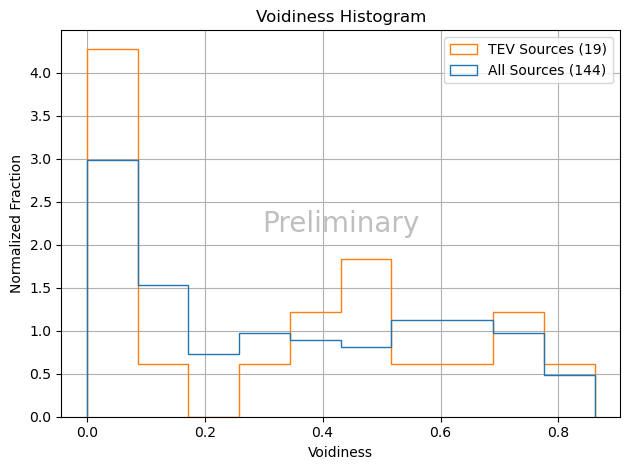

In [576]:
l_all = len(voidiness)
l_TEV = len(TEV_voidiness)

voidiness_list = [item for _, item in voidiness.items()]
TEV_voidiness_list = [item for _, item in TEV_voidiness.items()]
print(max(voidiness_list))
plot_hist_watermark([voidiness_list, TEV_voidiness_list], bins=10,
          xlabel='Voidiness',
          ylabel='Normalized Fraction',
          title='Voidiness Histogram',
          watermark_text='Preliminary',
          label=[f'All Sources ({l_all})', f'TEV Sources ({l_TEV})'],
          density=True)
# ax.text(0.5, 0.5, 'created with matplotlib', transform=ax.transAxes,
#         fontsize=40, color='gray', alpha=0.5,
        # ha='center', va='center', rotation=30)

voidiness  vs spectral index
voidiness vs. integral flux

Redo Void coincidence with sdss galaxies



### Voidiness Line Plots

In [577]:
# Testing logic to splice up Large list into smaller list and handling the 
# remaining elements~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sub_len = 10
l = range(0,101)
n_full_rows = len(l)//sub_len
rem = len(l)%sub_len

new_l = []
for i in range(n_full_rows):
    new_l.append(l[0+sub_len*i:sub_len*(i+1)])

if rem:
    new_l.append(l[-rem:])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

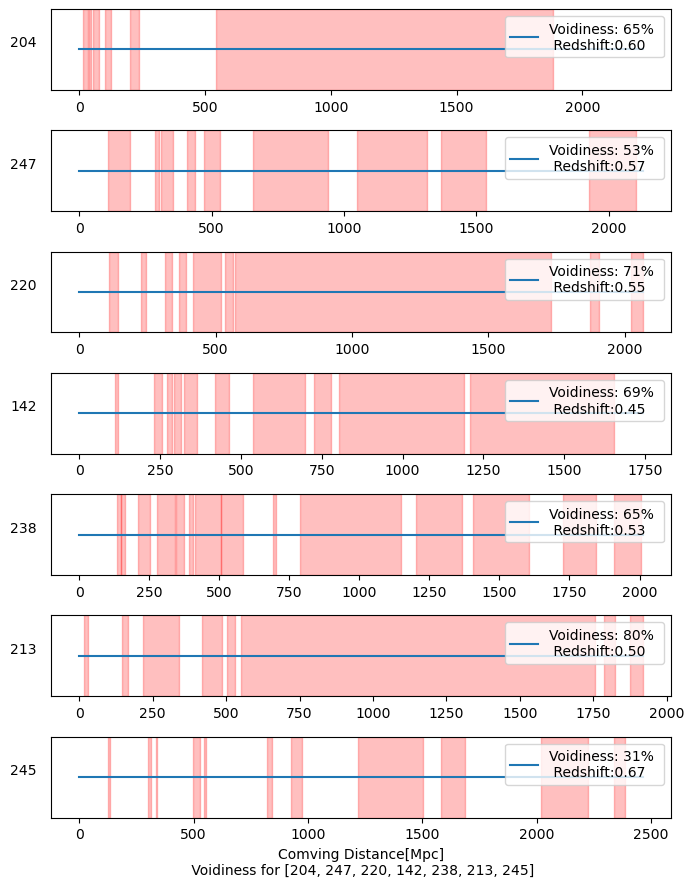

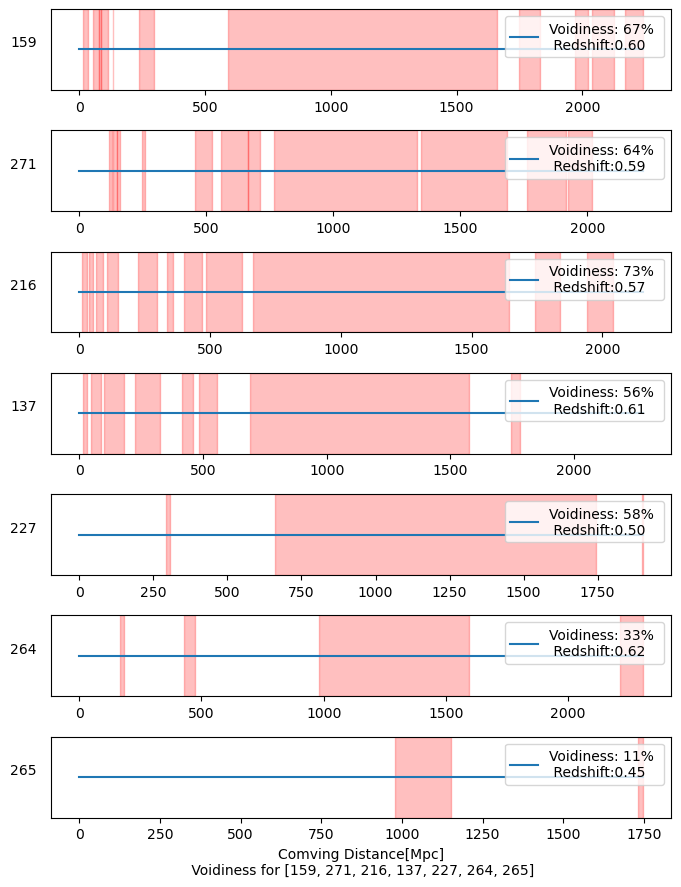

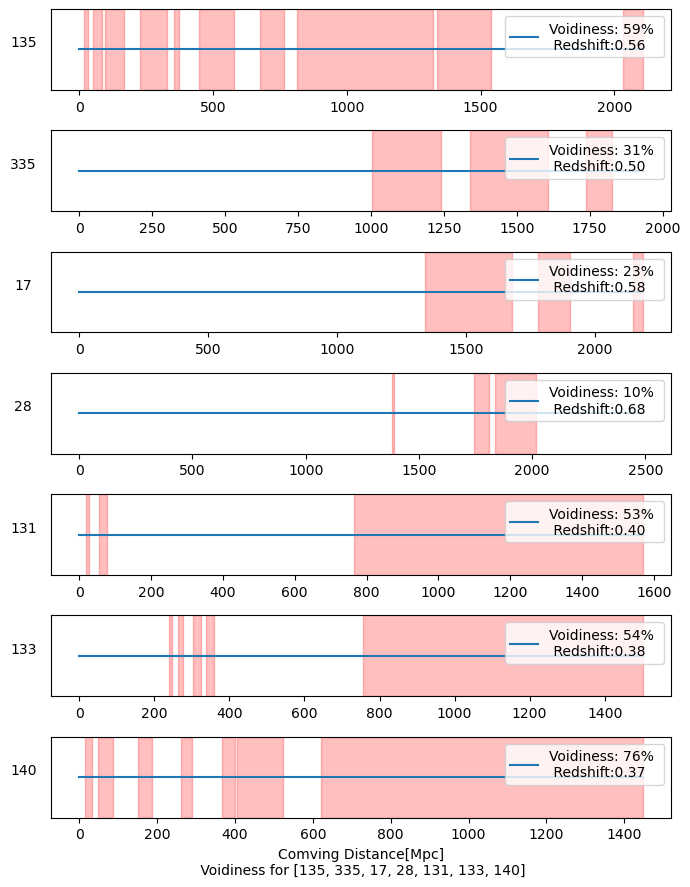

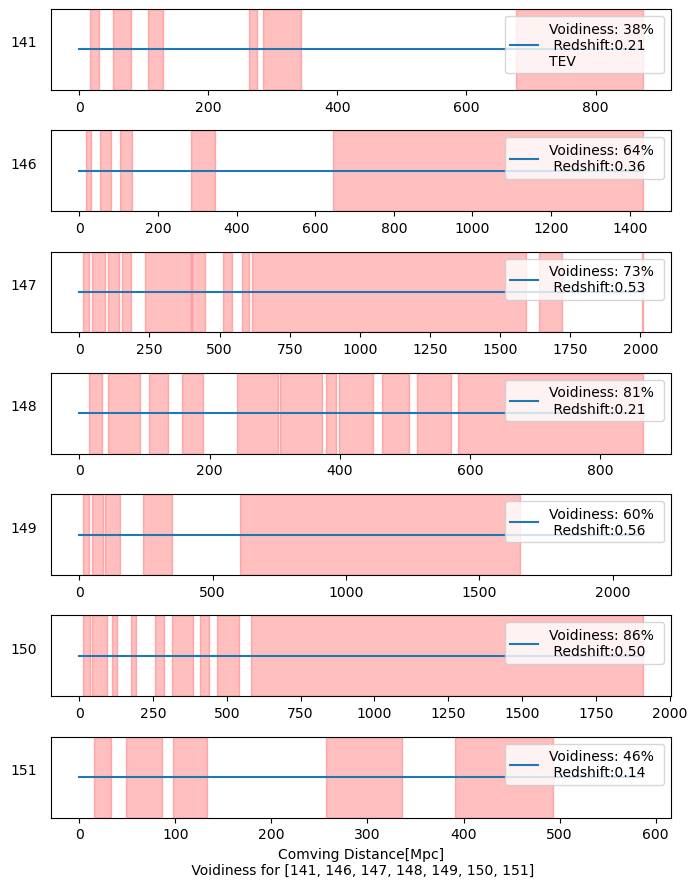

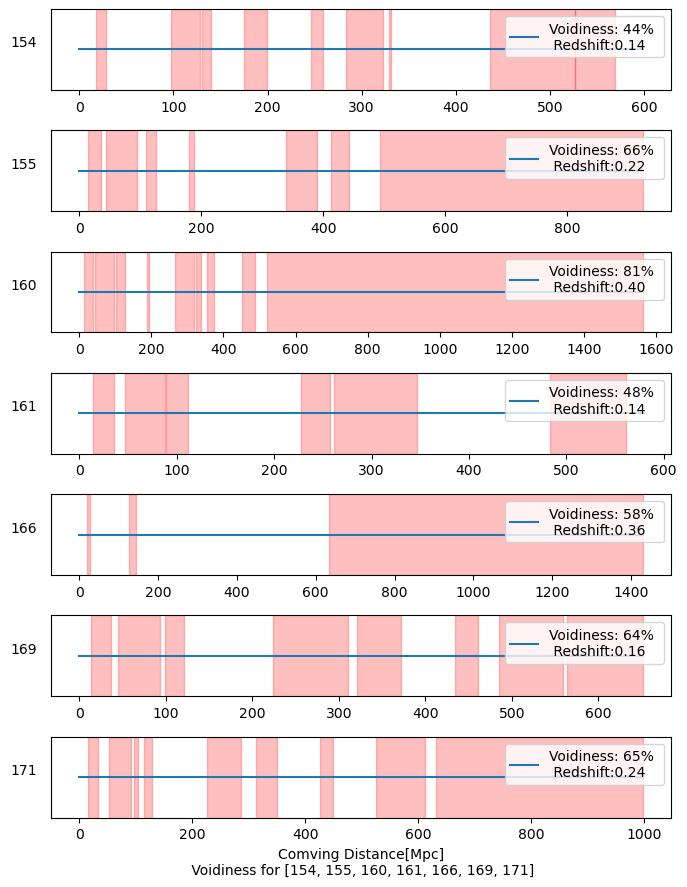

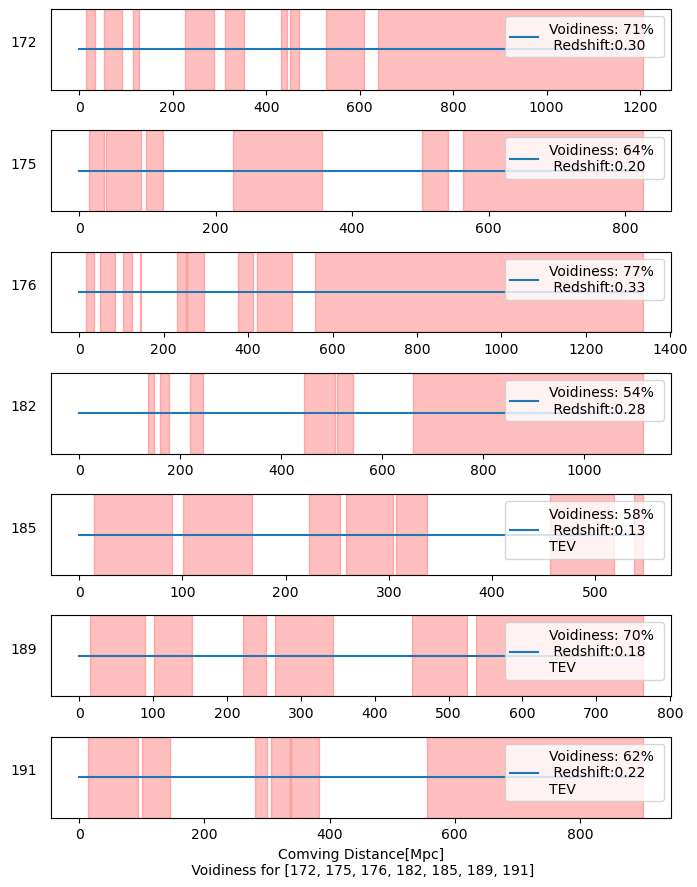

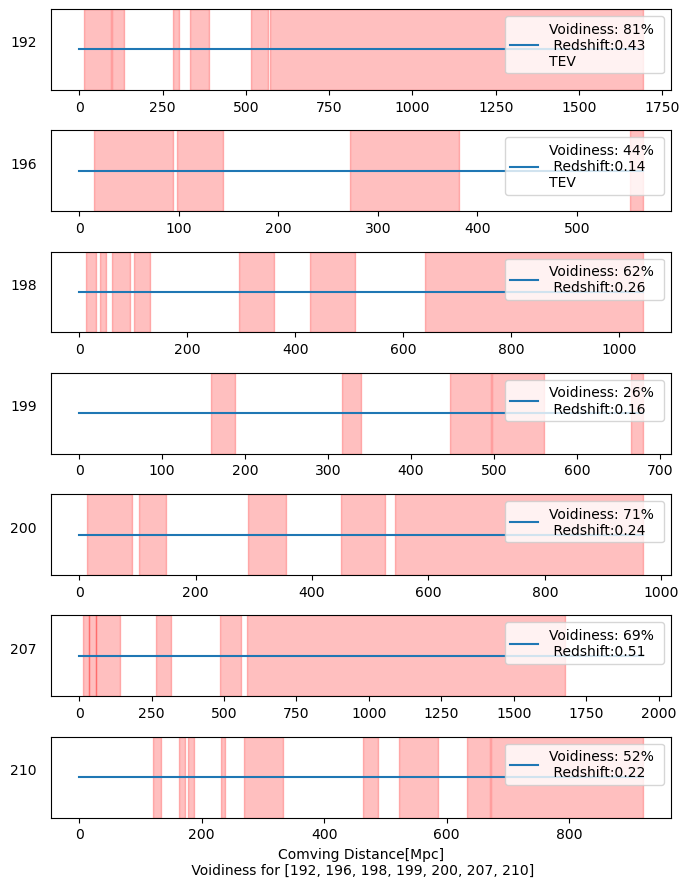

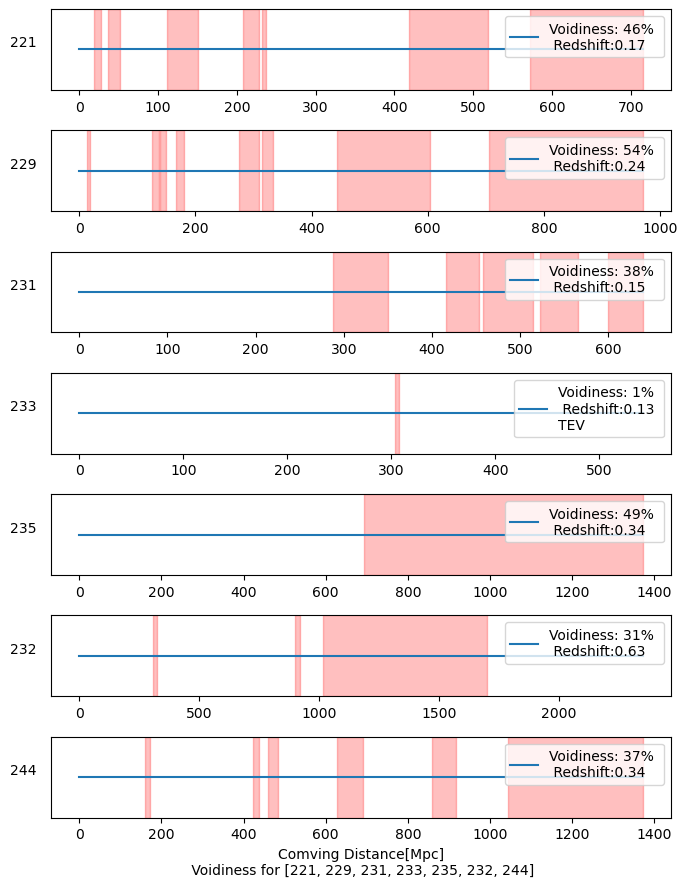

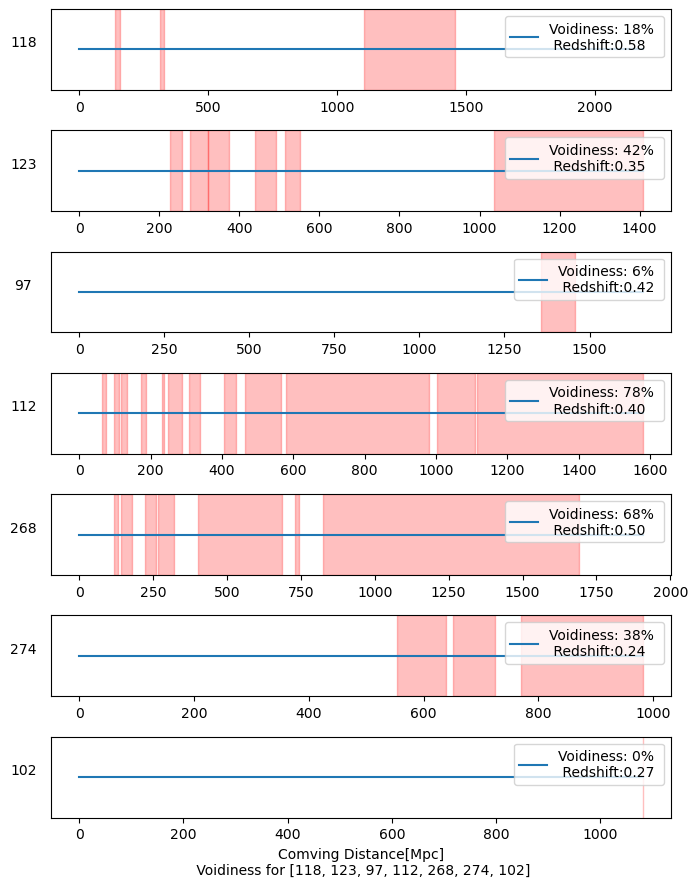

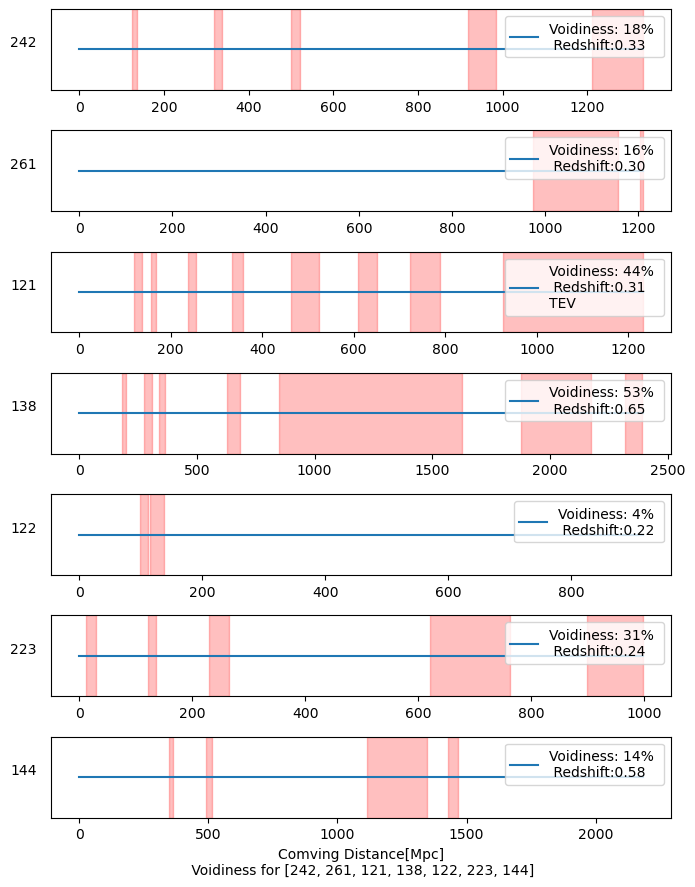

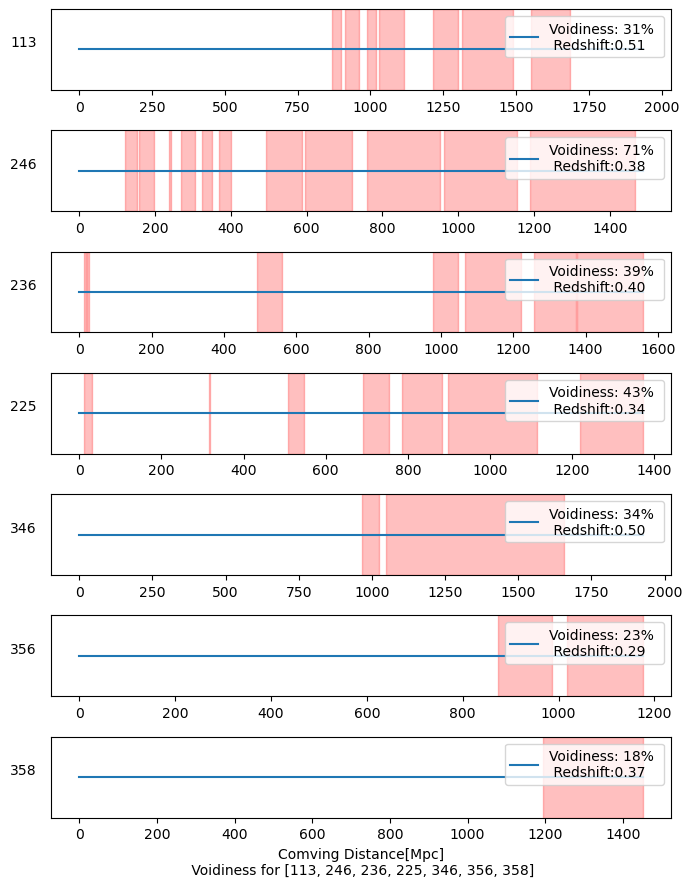

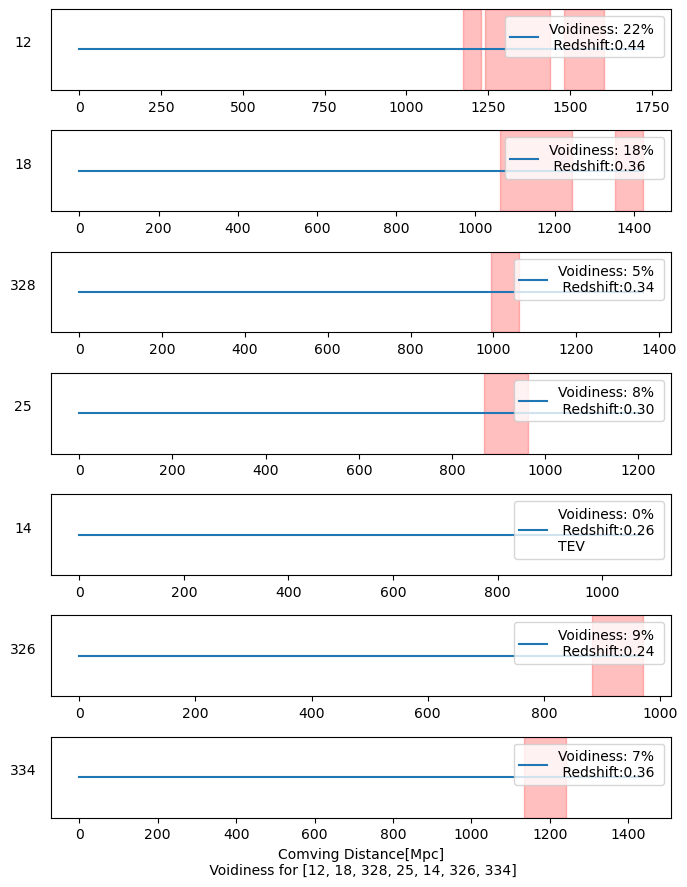

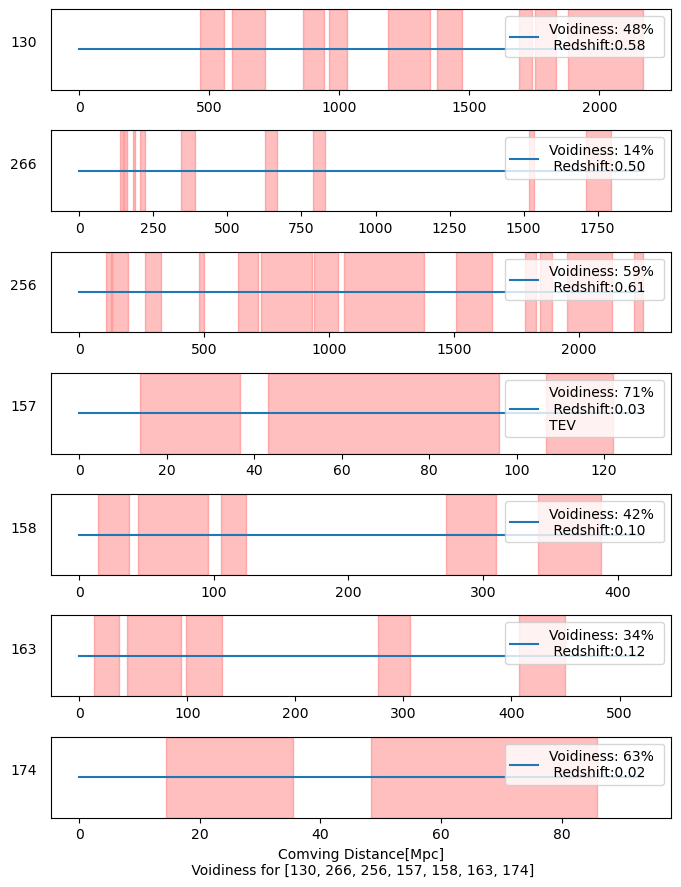

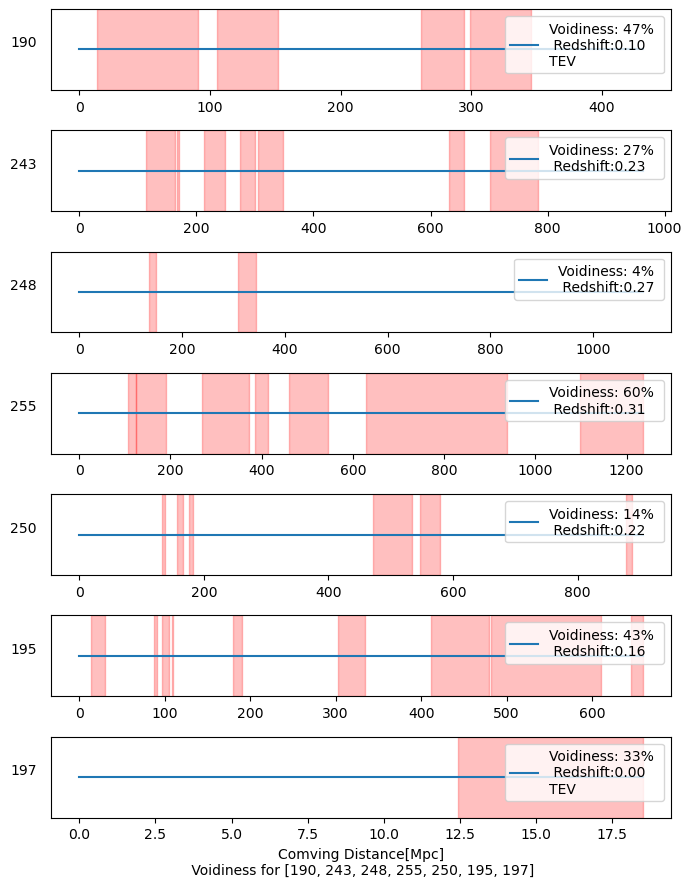

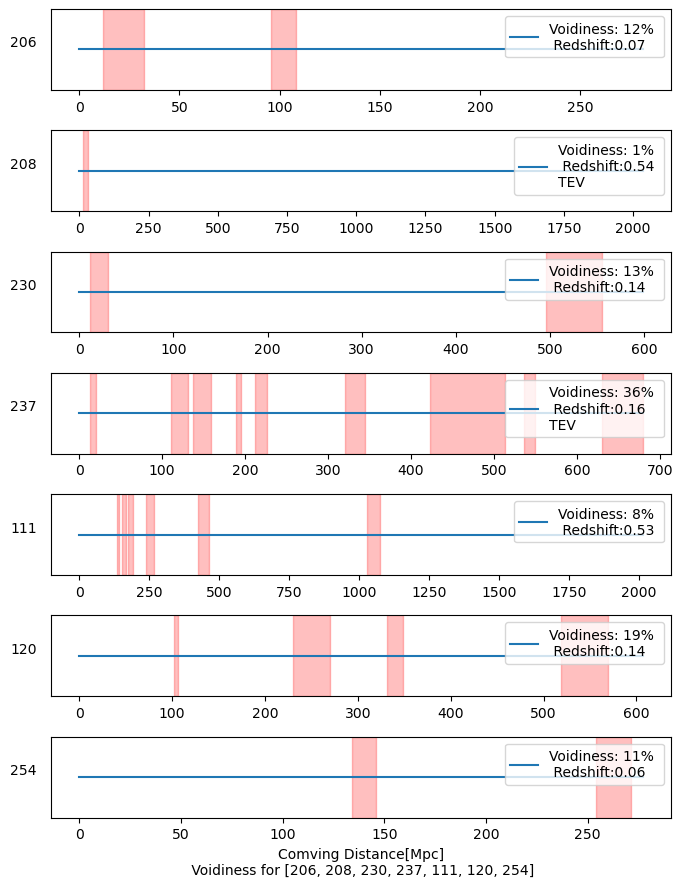

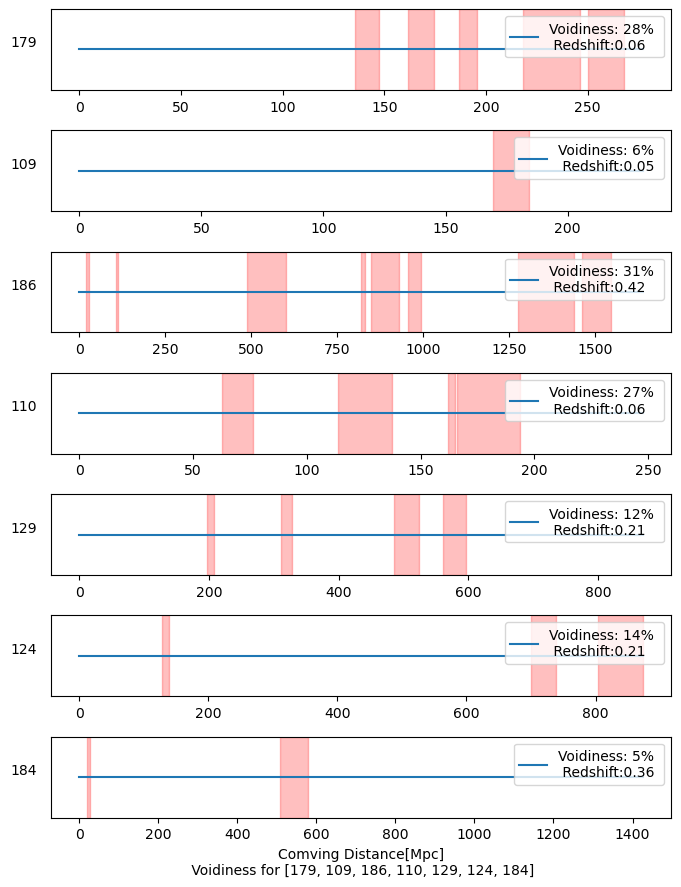

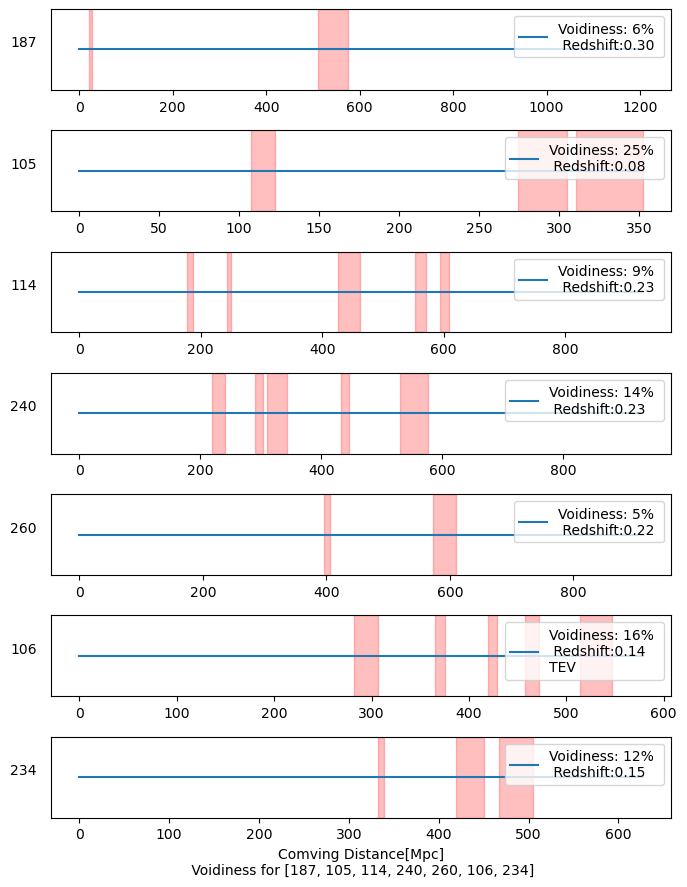

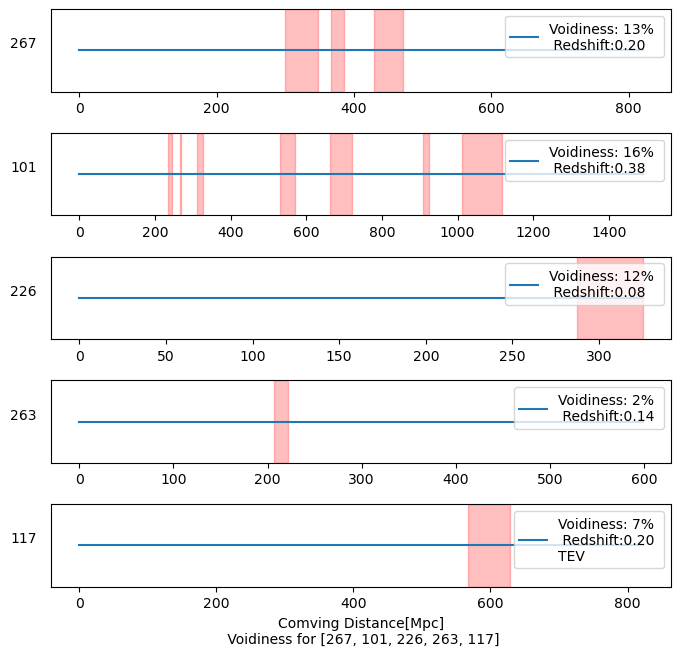

In [578]:
# Declaring some initial variables
num_r = 7 # Number of rows per subplot
width = 8 # inches. 
dr = "./output_plots/Voidiness_line_plots/" # Directory to save plots

# Chop up large list of GRS indices into sublists~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
n_full_rows  = len(src_keys)//num_r # Number of full rows without empty gaps
rem = len(src_keys)%num_r # Remainder 

chopped_keys = []
for i in range(n_full_rows):
    # Grab i'th group of num_r src keys
    chopped_keys.append(src_keys[0+num_r*i:num_r*(i+1)])

if rem:
    chopped_keys.append(src_keys[-rem:])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Batch count number and save plots
batch_no = 1
total_batches = len(chopped_keys)
for sub_list in chopped_keys:
    sub_len = len(sub_list)

    fig, axs = plt.subplots(nrows=sub_len, figsize=(width, sub_len*1.5))

    for grs, ax in zip(sub_list, axs.flat):
        

        voidiness_i = voidiness[grs] # Voidiness percent

        cmvd_i = work_vhe.loc[grs, 'cmvd_Mpc'] # Comoving distance to GRS
        z_i = work_vhe.loc[grs, 'z']

        v_id = vhes[grs]['void_idx'] # Incident void Ids with current GRS

        # Create ranges of voidiness to show on plot~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # This is with approximation.
        v_cmvd_mpc = voids.loc[v_id, 'cmvd_Mpc'].values
        v_r_mpc = voids.loc[v_id, 'Reff_Mpc'].values

        v_r_mpc *= (4/3) /2

        void_ranges = []
        void_intervals = vhes[grs]['intervals']
        union = take_union(void_intervals)
        # for o, r in zip(v_cmvd_mpc, v_r_mpc): # This produces the old line graphs that overlap
        #     void_ranges.append((o-r, o+r))

        # Now we are actually using the union method
        for v_int in union:
            # v_int.low
            if np.issubdtype(type(v_int.lower), float): # protects against empty intervals
                low = v_int.lower * cmvd_i
                hi = v_int.upper * cmvd_i
                void_ranges.append((low, hi))



        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        # I will now use the actual interval

        ax.plot([0,cmvd_i],[1,1])
        ax.set_ylabel(grs, rotation=0, labelpad=20)
        ax.set_yticks([])
        # ax.set_xlabel("Comoving Distance [Mpc]")
        # Add TEV Flag
        if vhes[grs]["TEV_Flag"]:
            tev_flag = "\nTEV"
        else:
            tev_flag = ""
        
        ax.legend([f"Voidiness: {voidiness_i*100:.0f}% \n Redshift:{z_i:.2f}"  + tev_flag], loc="upper right")

        # Color in voidy regions
        for start, end in void_ranges:
            ax.axvspan(start, end, color='red', alpha=0.25)

    # plt.title(f"Voidiness for{sub_list}")
    plt.xlabel(f"Comving Distance[Mpc]\n Voidiness for {sub_list}")

    plt.subplots_adjust(hspace=0.5)
    
 
    plt.savefig(dr + "Using_intervals" + f"Batch_no_{batch_no}_of_{total_batches}.jpg")
    batch_no += 1



In [579]:
intersting_voids = [142, 268, 112, 176, 198, 199, 138]
work_vhe.loc[intersting_voids]

,OG_idx,Source_Name,RAdeg,DEdeg,z,TEVCAT_FLAG,Spectral_Index,Unc_Spectral_Index,Flux,Unc_Flux,...,Unc_Flux_Band_1_b,Unc_Flux_Band_2_a,Unc_Flux_Band_2_b,Unc_Flux_Band_3_a,Unc_Flux_Band_3_b,Unc_Flux_Band_4_a,Unc_Flux_Band_4_b,cmvd_Mpc,RAdeg_gal,DEdeg_gal
142,142,b'3FHL J1026.9+0608 ',156.740356,6.142007,0.44900,b'N',1.707424,0.731575,3.103263e-11,1.222811e-11,...,8.306265e-12,-2.543978e-12,4.976075e-12,NaN,5.499207e-12,NaN,6.412181e-12,1743.428172,237.747675,49.781412
268,268,b'3FHL J1626.2+3515 ',246.574768,35.262291,0.49738,b'N',1.318621,0.691001,2.254689e-11,9.101243e-12,...,8.785571e-12,-2.051363e-12,3.925008e-12,NaN,4.401563e-12,NaN,4.984420e-12,1907.322882,56.963032,43.892147
112,112,b'3FHL J0820.9+2353 ',125.234398,23.892050,0.40200,b'N',1.655285,0.867119,2.403112e-11,1.020560e-11,...,6.121383e-12,-4.495114e-12,6.954797e-12,NaN,5.774799e-12,NaN,5.617079e-12,1579.826052,199.510480,29.632655
176,176,b'3FHL J1153.2+4929 ',178.322464,49.492622,0.33400,b'N',2.766547,1.396879,1.995787e-11,8.506905e-12,...,4.045991e-12,NaN,4.327271e-12,NaN,4.331603e-12,NaN,4.698461e-12,1335.360207,145.620482,64.995649
198,198,b'3FHL J1231.4+1422 ',187.866241,14.368031,0.25600,b'N',1.948881,0.551797,5.251133e-11,1.486934e-11,...,1.073305e-11,-3.716006e-12,6.376861e-12,NaN,5.273412e-12,NaN,6.011282e-12,1043.496526,281.892117,76.417078
199,199,b'3FHL J1231.6+6415 ',187.905457,64.266304,0.16300,b'N',1.281024,0.472515,4.176810e-11,1.115742e-11,...,9.671598e-12,-2.846325e-12,4.517775e-12,NaN,3.660223e-12,NaN,4.107501e-12,679.444441,126.481357,52.725169
138,138,b'3FHL J1008.0+0622 ',152.004135,6.373632,0.65000,b'N',2.011515,0.515694,8.282949e-11,1.915609e-11,...,1.247298e-11,-2.523715e-12,4.908898e-12,NaN,5.455457e-12,NaN,6.140839e-12,2395.304963,233.500961,46.022566


### Plotting voidiness vs Spectral inex and Flux

In [580]:
grsources = list(vhes.keys())
TEVs = []

# TEVs = grsources[vhes[grsources]["TEV_Flag"]]
for g in grsources:
    if vhes[g]["TEV_Flag"]:
        TEVs.append(g)


nonTEVs = [item for item in grsources if item != TEVs]



SPEC_index = work_vhe.loc[nonTEVs, "Spectral_Index"].values
SPEC_uncert = work_vhe.loc[nonTEVs, "Unc_Spectral_Index"].values

# Flux = work_vhe.loc[grsources, "Flux"].values
# Flux_uncert = work_vhe.loc[grsources, "Unc_Flux"].values




Text(0, 0.5, 'Spectral Index')

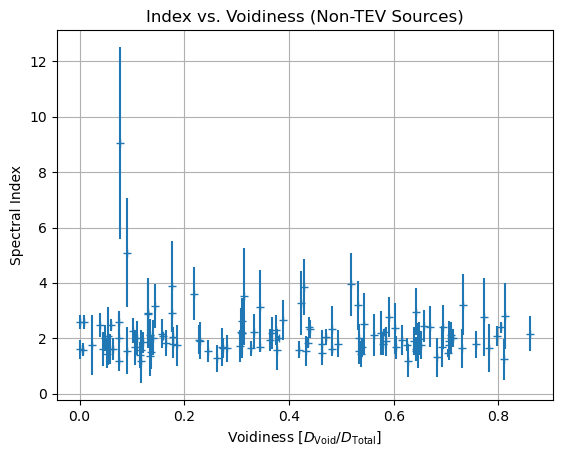

In [581]:
# Plots with bins
SPEC_index = work_vhe.loc[nonTEVs, "Spectral_Index"].values
SPEC_uncert = work_vhe.loc[nonTEVs, "Unc_Spectral_Index"].values

# Flux = work_vhe.loc[grsources, "Flux"].values
# Flux_uncert = work_vhe.loc[grsources, "Unc_Flux"].values

voidis= []
for grs in nonTEVs:
    voidis.append(vhes[grs]["Voidiness"])

plt.errorbar(voidis, SPEC_index, yerr=SPEC_uncert, linestyle='', marker = "+")
plt.grid()
plt.title("Index vs. Voidiness (Non-TEV Sources)")
plt.xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]")
plt.ylabel("Spectral Index")
# plt.savefig("./output_plots/nsf_proposal/Index_Voidiness_(Non-TEV_Sources).PS")



In [582]:
# Consolidate the uncertainties to be consistent. 1 value for each data point.
# The asymmetric flux are made symmetric by calcualting the mid points. 
# The actual flux data point is plotted seperately. 

flux_bands = work_vhe.loc[nonTEVs, col_names_flux].values
unc_flux = work_vhe.loc[nonTEVs, col_names_unc]

faux_unc = np.zeros((5, len(unc_flux)))
faux_flux = np.zeros((5, len(unc_flux)))
for i in range(5):
    for j in range(len(unc_flux)):
        temp_unc = unc_flux.iloc[j, 0+i*2:2+i*2]
        has_nan = any(np.isnan(x) for x in temp_unc)
        if has_nan: # Single value uncertainty
            num = [x for x in temp_unc if not np.isnan(x)][0] #[0] grabs the one value without putting it in a list
            faux_unc[i, j] = num
            faux_flux[i, j] = flux_bands[j, i]
        else: # Does not have nans, asymmetric uncertainty.
            actual_flux = flux_bands[j, i]
            uncerts = actual_flux + temp_unc
            faux_flux[i, j] = np.mean(uncerts) # calculate centroid of uncerts
            faux_unc[i, j]  = max(uncerts) - faux_flux[i, j]




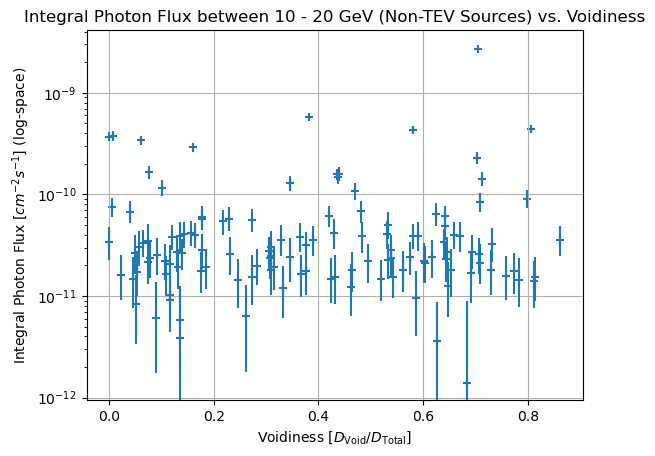

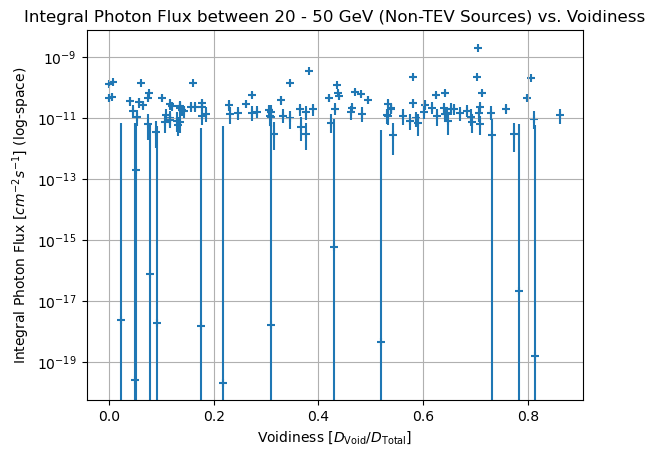

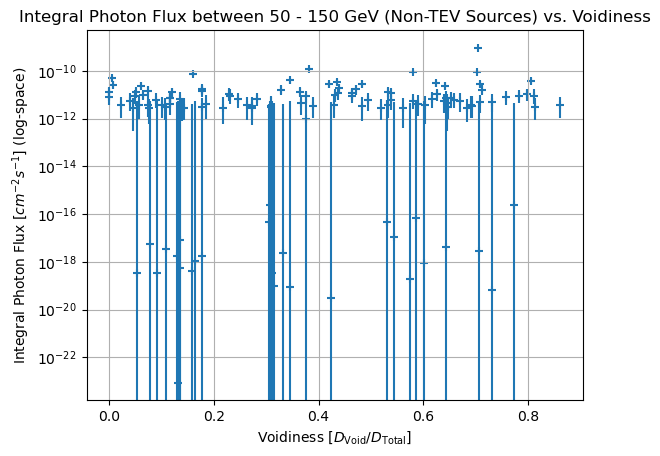

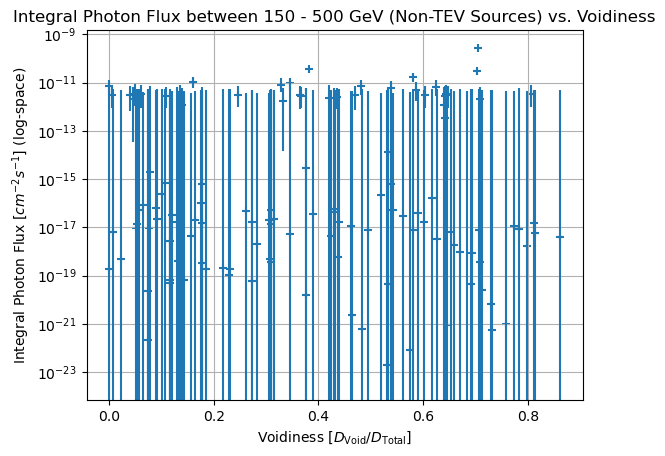

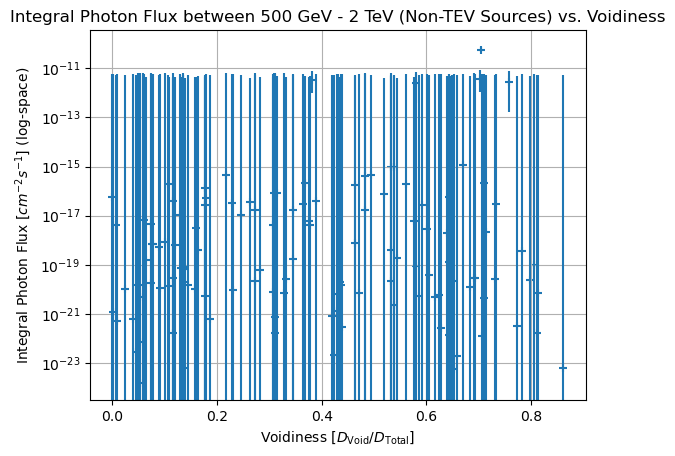

In [583]:
# Exclude TEVS in this one
bands = ["10 - 20 GeV",
         "20 - 50 GeV",
         "50 - 150 GeV",
         "150 - 500 GeV",
         "500 GeV - 2 TeV"]

fn_bands = ["10_20",
         "20_50",
         "50_150",
         "150_500",
         "500_2_TeV"]

for i in range(5):
    plt.figure()
    plt.errorbar(voidis, faux_flux[i, :], yerr=faux_unc[i,:], linestyle='')
    plt.yscale('log')
    plt.scatter(voidis, flux_bands[:, i], marker='+')
    plt.grid()
    title = "Integral Photon Flux between " + bands[i] + " (Non-TEV Sources) vs. Voidiness"
    plt.title(title)
    plt.xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]")
    plt.ylabel("Integral Photon Flux [$cm^{-2} s^{-1}$] (log-space)")
    dirs = "./output_plots/nsf_proposal/"
    fn = "Integral_Photon_Flux_between_" + fn_bands[i] + "_(Non-TEV_Sources)_vs_Voidiness.PS"
    # plt.savefig(dirs + fn)

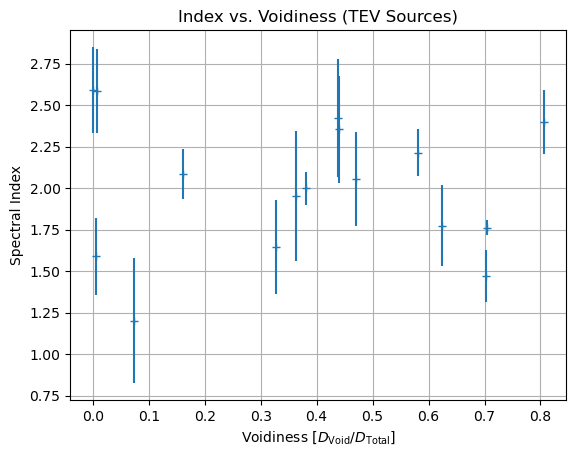

In [584]:
# Plots with bins
SPEC_index = work_vhe.loc[TEVs, "Spectral_Index"].values
SPEC_uncert = work_vhe.loc[TEVs, "Unc_Spectral_Index"].values

# Flux = work_vhe.loc[TEVs, "Flux"].values
# Flux_uncert = work_vhe.loc[TEVs, "Unc_Flux"].values

voidis= []
for grs in TEVs:
    voidis.append(vhes[grs]["Voidiness"])

plt.errorbar(voidis, SPEC_index, yerr=SPEC_uncert, linestyle='', marker = "+")
plt.grid()
plt.title("Index vs. Voidiness (TEV Sources)")
plt.xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]")
plt.ylabel("Spectral Index")
dirs = "./output_plots/nsf_proposal/"
fn = "Spectral_TEV_vs_Voidiness.PS"
# plt.savefig(dirs + fn)

# plt.figure()
# plt.title("Flux vs. Voidiness TEVs")
# plt.xlabel("Voidiness")
# plt.ylabel("Flux")
# plt.errorbar(voidis, Flux, yerr=Flux_uncert, linestyle='', marker="+")
# plt.grid()

In [585]:
# Consolidate the uncertainties to be consistent. 1 value for each data point.
# The asymmetric flux are made symmetric by calcualting the mid points. 
# The actual flux data point is plotted seperately. 

flux_bands = work_vhe.loc[TEVs, col_names_flux].values
unc_flux = work_vhe.loc[TEVs, col_names_unc]
voidis= []
for grs in TEVs:
    voidis.append(vhes[grs]["Voidiness"])
    
faux_unc = np.zeros((5, len(unc_flux)))
faux_flux = np.zeros((5, len(unc_flux)))
for i in range(5):
    for j in range(len(unc_flux)):
        temp_unc = unc_flux.iloc[j, 0+i*2:2+i*2]
        has_nan = any(np.isnan(x) for x in temp_unc)
        if has_nan: # Single value uncertainty
            num = [x for x in temp_unc if not np.isnan(x)][0] #[0] grabs the one value without putting it in a list
            faux_unc[i, j] = num
            faux_flux[i, j] = flux_bands[j, i]
        else: # Does not have nans, asymmetric uncertainty.
            actual_flux = flux_bands[j, i]
            uncerts = actual_flux + temp_unc
            faux_flux[i, j] = np.mean(uncerts) # calculate centroid of uncerts
            faux_unc[i, j]  = max(uncerts) - faux_flux[i, j]




In [586]:
TEVs[9]

157

In [587]:
vvv = flux_bands[:,0]

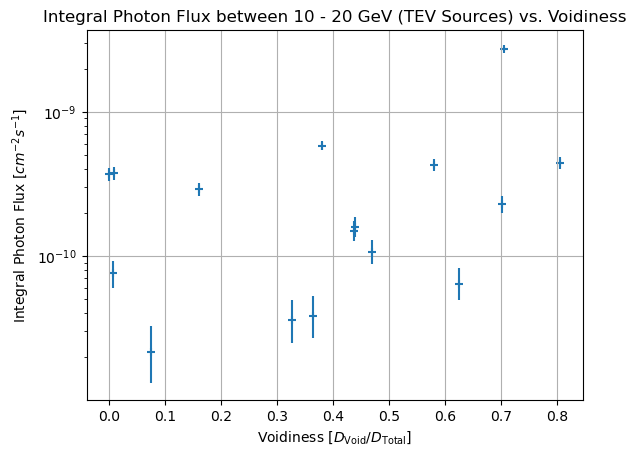

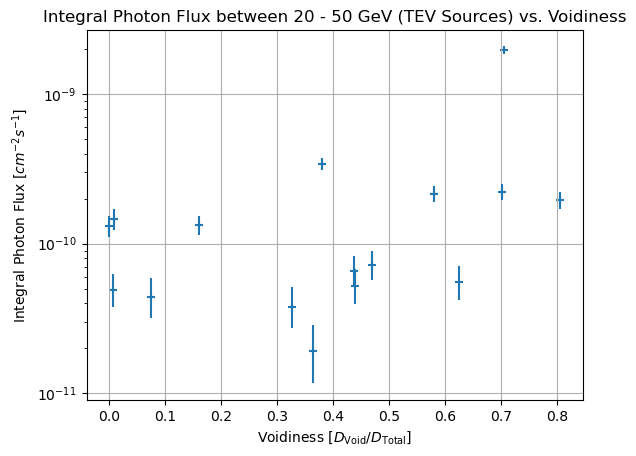

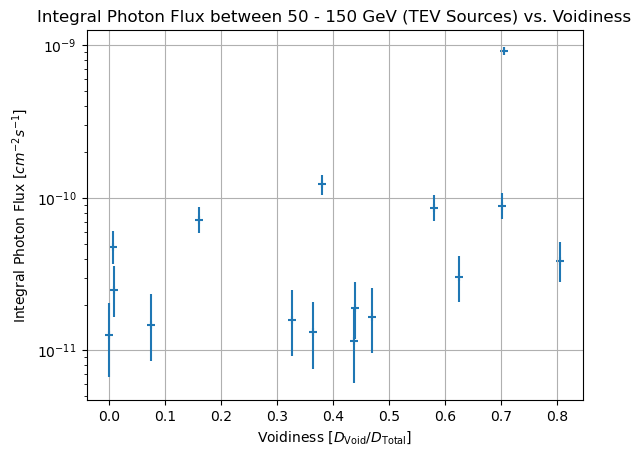

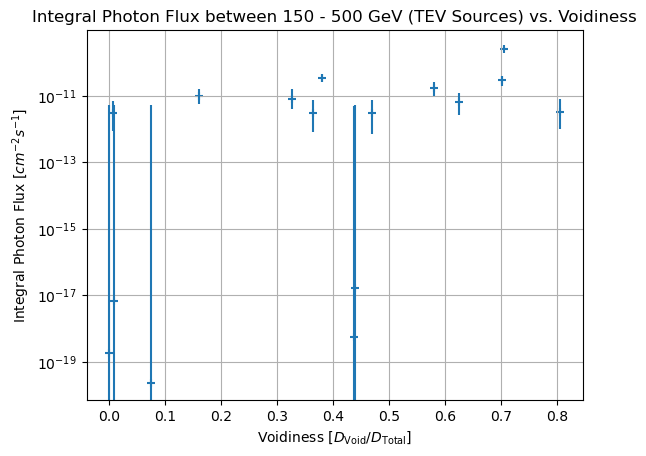

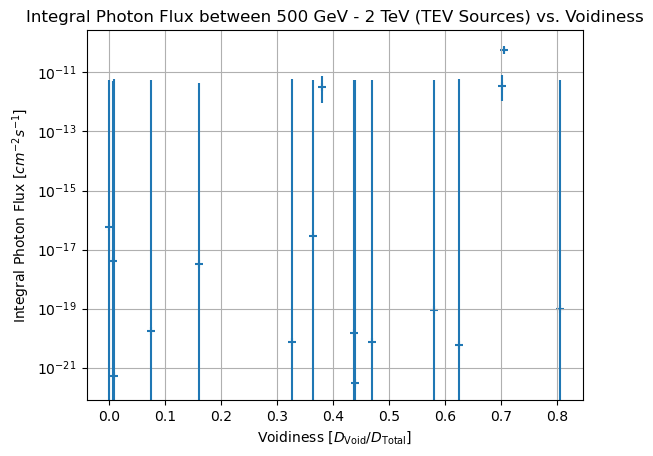

In [588]:
bands = ["10 - 20 GeV",
         "20 - 50 GeV",
         "50 - 150 GeV",
         "150 - 500 GeV",
         "500 GeV - 2 TeV"]
fn_bands = ["10_20",
         "20_50",
         "50_150",
         "150_500",
         "500_2_TeV"]

for i in range(5):
    plt.figure()
    plt.errorbar(voidis, faux_flux[i, :], yerr=faux_unc[i,:], linestyle='')
    plt.scatter(voidis, flux_bands[:, i], marker='+')
    plt.yscale('log')
    plt.grid()
    plt.title("Integral Photon Flux between " + bands[i] + " (TEV Sources) vs. Voidiness")
    plt.xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]")
    plt.ylabel("Integral Photon Flux [$cm^{-2} s^{-1}$]")
    dirs = "./output_plots/nsf_proposal/"
    fn = "Integral_Photon_Flux_between_" + fn_bands[i] + "_(TEV_Sources)_vs_Voidiness.PS"
    # plt.savefig(dirs + fn)


In [ ]:
# Line fit on Tevs Spectral vs Voidiniess curve

def line(x,m, b):
    return m * x + b

popt, pcov = curve_fit(line, voidis, SPEC_index, sigma=SPEC_uncert)

plt.plot(voidis, line(voidis, *popt))
plt.errorbar(voidis, SPEC_index, yerr=SPEC_uncert)

In [ ]:
voidis

# Statistical Analysis

### Distance Histograms

#### Prelim Histograms for Debugging

In [ ]:
# Defining some Useful base plotting parameters
xlabel = 'Distance Deg'
ylabel = 'Count'
base_title = 'Distances.'

##### Fermi Data

In [ ]:
vhe_seps = dist_w_skycoord(vhe_coords_gal) 
# verify_combo_count(vhe_seps, n=len(vhe_coords_gal)) # If its quiet we are good. 

##### Random Data

In [ ]:
if masked:
    mask = MASK_deg # apply 10 degree mask
else:
    mask = 0 # no mask
rand_coords_gal = generate_rand_Coords_static(len(vhe_coords_cel), mask = mask, seeded=False)
rand_coords_cel = rand_coords_gal.fk5 # book keeping

In [ ]:
rand_seps = dist_w_skycoord(rand_coords_gal)

In [ ]:
labels = ["FERMI", "Random Data"]

In [ ]:
plot_hist([vhe_seps, rand_seps],
          label=labels,
          xlabel = xlabel,
          ylabel = 'Percent',
          title = base_title + f' Masked: {masked}',
        #   bins = 3,
        # histtype='bar',
        # stacked=True,
          )

In [ ]:
plot_hist([vhe_coords_gal.l.value, rand_coords_gal.l.value],
          label=labels,
          title = f'Galactic Longitude (l) Distribution. Masked: {masked}',
          xlabel = 'Angle Deg',
          ylabel = 'Percent',
          bins=75)
plot_hist([vhe_coords_gal.b.value, rand_coords_gal.b.value],
          label = labels,
          title = f'Galactic Latitude (b) Distribution. Masked: {masked}',
          xlabel = 'Angle Deg',
          ylabel = 'Percent',
          bins=75)

In [ ]:
# generate_rand_l_and_b(1000) # quickly testing they are independen distributions

In [ ]:
# Fermi and Random plot in Celestial
ax = plt.axes(projection="geo aitoff")
ax.grid()
rand_coords_cel
ax.scatter(rand_coords_cel.ra.deg, rand_coords_cel.dec.deg,
           transform=ax.get_transform('world'),
           s=1,
           marker='o',
           label='Random Points',
        )
ax.scatter(vhe_coords_cel.ra.deg, vhe_coords_cel.dec.deg,
           transform=ax.get_transform('world'),
           s=1,
           marker='o',
           label='Fermi Data',
        )
plt.legend(loc="lower right")
plt.title(f"Coordinate Skymap, Celestial, Mask: {masked}")

In [ ]:
# Fermi and and random plot in galactic
ax = plt.axes(projection="geo aitoff")
ax.grid()
rand_coords_cel
ax.scatter(rand_coords_gal.spherical.lon.deg, rand_coords_gal.spherical.lat.deg,
           transform=ax.get_transform('world'),
           s=1,
           marker='o',
           label='Random Points',
        )
ax.scatter(vhe_coords_gal.spherical.lon.deg, vhe_coords_gal.spherical.lat.deg,
           transform=ax.get_transform('world'),
           s=1,
           marker='o',
           label='Fermi Data',
        #    c=void_table['z'],
        #    alpha = 0.4
        )
plt.legend(loc="lower right")
plt.title(f"Coordinate Skymap, Galactic, Mask: {masked}")

In [ ]:
pls = generate_rand_Coords_static(len(vhe_coords_cel))

In [ ]:
len(vhe_coords_cel)

#### Little Bit to figure out average number of coordinates cut out. 

In [ ]:
# Little bit of code to figure out mean number of coordinates cut out by mask
# Then add them to total number of random coordinates generated


# if True:
#     n = 10000000
#     n_coords = np.zeros(n)
#     len_vhe = len(vhe_coords)
#     with Pool(12) as p:
#         n_coords = p.map(len_gen_coords, [len_vhe] * n)

#     mean_n_cut = len_vhe - np.mean(n_coords) # 211 from 10,000,000 samplings

#### Sampling and Analysis

In [ ]:
# 1000 samples block takes ~ 5 min
n_coords = len(vhe_coords_gal) # number of coordinates to produce
n_samples = 10
BATCH_COUNT = 1

file_name = f'./Random_Data/test_{BATCH_COUNT}.pickle'
for i in range(10):
    with Pool(12) as p:
        rand_seps = p.map(sample_and_measure, [n_coords]*n_samples) # Nested list
    
    if BATCH_COUNT % 10 ==0: # Multiple of 10
        BATCH_COUNT += 1
        file_name = f'test_{BATCH_COUNT}.pickle'

    # Save rand_seps into a CSV file, overwriting the file each time.
    with open(file_name, 'ab') as file:
        pickle.dump(rand_seps, file)
    

In [ ]:
with open(file_name, 'rb') as file:
    save_data = pickle.load(file)

Take mean,for a single bin.

In [ ]:
flattened_seps = list(chain.from_iterable(rand_seps)) # Chain is faster

In [ ]:
# df = pd.DataFrame(rand_seps) # 2 mins for a 50 x 544,446 table. maybe pandas is not the way to go. 
# # if this was a 1000 table. this would take significantly longer.

In [ ]:
n_bins = 180
bins = np.linspace(0,180, n_bins + 1)

In [ ]:
# bin_indices = np.digitize(rand_seps, bins) - 1 # To fix 0 indexing


In [ ]:
# bin_indices

In [ ]:
# print(bin_indices == 89)

In [ ]:
# test_bi = bin_indices[0]

In [ ]:
# pandas has methods for handling large data sets
# df = pd.DataFrame({"Seperations": flattened_seps, "Bin": bin_indices})

In [ ]:
# bin_statistics = df.groupby('Bin')['Seperations'].agg(['mean', 'std'])

In [ ]:

plot_hist([vhe_seps, flattened_seps],
          label=['FERMI', 'Random Data', '1 Sigma'],
          xlabel = xlabel,
          ylabel = 'Percent',
          title = base_title + f' Masked: {masked}',
        #   bins = 3,
        # histtype='bar',
        # stacked=True,
          )